In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import calendar as cld
import matplotlib.pyplot as plt
import matplotlib.colors
colors_land = plt.cm.terrain(np.linspace(0.25, 1, 256))
import proplot as pplt # New plot library (https://proplot.readthedocs.io/en/latest/)
pplt.rc['savefig.dpi'] = 300 # 1200 is too big! #https://proplot.readthedocs.io/en/latest/basics.html#Creating-figures
from scipy.stats import chi2
from numba import njit,prange
import matplotlib as mpl
mpl.rcParams['hatch.linewidth'] = 0.05  # previous pdf hatch linewidth
from matplotlib.dates import DateFormatter

In [2]:
# function for seasonal mean (from Ian)
def season_mean(ds, calendar="standard"):
    #make a DataArray with the season of each day
    seas_array = ds.time.dt.season
    
    # count days in winter season (varies with leap years)
    nb_DJF = seas_array.str.count('DJF').sum()
    
    wgt_DJF = 1/nb_DJF.values.item()
    wgt_MAM = 1/(31+30+31)
    wgt_JJA = 1/(30+31+31)
    wgt_SON = 1/(30+31+30)

    weight = seas_array.str.replace('DJF',str(wgt_DJF)).str.replace('MAM',str(wgt_MAM)).str.replace('JJA',str(wgt_JJA)).str.replace('SON',str(wgt_SON))
    weight = weight.astype('float')
    
    # Test that the sum of the weights for each season is 1.0
    np.testing.assert_allclose(weight.groupby("time.season").sum().values, np.ones(4))

    # Calculate the weighted average
    return (ds * weight).groupby("time.season").sum(dim="time")

In [39]:
def detect_alps(H):
    nlat,nlon = np.shape(H)
    mask = np.bool_(np.zeros((nlat,nlon)))
    r = 4
    for j in range(r,nlat-r):
        for i in range(r,nlon-r):
            mask[j,i] = np.logical_and(H[j,i]>360 ,np.any(H[j-r:j+r,i-r:i+r]>1300))
            # mask[j,i] = np.std(H[j-r:j+r,i-r:i+r])>200
    return mask
alps = detect_alps(H)
alps[lon<4.8] = False
alps[np.logical_and(lon>10,lat<45.2)] = False

In [3]:
normal_format = {'gridlinewidth':0.1, 'gridcolor':'gray8', 'gridalpha':0.5, 'coast':True,'borders':True ,'reso':'hi', 'labels':True, 'lonlines':2, 'latlines':2, 'abc':False, 'latlim':[43.,48.5],'lonlim':[4.,16.]}
multiplot_format = {'gridlinewidth':0.1, 'gridcolor':'gray8', 'gridalpha':0.5, 'coast':True,'borders':True ,'reso':'hi', 'labels':False, 'lonlines':2, 'latlines':2, 'abc':False, 'latlim':[43.,48.5],'lonlim':[4.,16.]}



In [4]:
ds = xr.open_dataset('/bettik/beaumetj/MARout/MAR-EC-Earth3/MARgrid_EUe.nc')

imin = 32 ; imax = -30
jmin = 20 ; jmax = -15
lon = np.array(ds.LON[jmin:jmax,imin:imax])
lat = np.array(ds.LAT[jmin:jmax,imin:imax])
H = np.array(ds.SH[jmin:jmax,imin:imax])
nlat,nlon = 91, 139

In [5]:
ds_T_test_v314 = xr.open_dataset('/bettik/castelli/data/MAR3.14/MAR-ERA5/testrun_1month/ICE.ERA5.EUa.TTz.09.2014.nc')
ds_T_test_v314

<xarray.Dataset>
Dimensions:  (time: 30, ztqlev: 3, y: 126, x: 201)
Coordinates:
  * time     (time) datetime64[ns] 2014-09-01T12:00:00 ... 2014-09-30T12:00:00
  * x        (x) float32 -483.0 -476.0 -469.0 -462.0 ... 896.0 903.0 910.0 917.0
  * y        (y) float32 -308.0 -301.0 -294.0 -287.0 ... 546.0 553.0 560.0 567.0
  * ztqlev   (ztqlev) float32 2.0 10.0 100.0
Data variables:
    TTz      (time, ztqlev, y, x) float32 ...
Attributes:
    title:        ICE - Exp: a01 - 20140901
    institution:  ULg (Xavier Fettweis)
    history:      Fri Feb 16 11:43:08 2024: ncks -v TTz /bettik/castelli/MARo...
    netcdf:       4.8.0 of May  2 2023 12:43:48 $
    NCO:          netCDF Operators version 5.0.6 (Homepage = http://nco.sf.ne...

In [6]:
ds_T_normal = xr.open_dataset('/bettik/beaumetj/MARout/MAR-ERA5/daily/ICE.ERA5_v1.EUl.TTz.2014.nc')
ds_T_normal

<xarray.Dataset>
Dimensions:  (time: 365, ztqlev: 4, y: 126, x: 201)
Coordinates:
  * time     (time) datetime64[ns] 2014-01-01T12:00:00 ... 2014-12-31T12:00:00
  * x        (x) float32 -483.0 -476.0 -469.0 -462.0 ... 896.0 903.0 910.0 917.0
  * y        (y) float32 -308.0 -301.0 -294.0 -287.0 ... 546.0 553.0 560.0 567.0
  * ztqlev   (ztqlev) float32 2.0 10.0 50.0 100.0
Data variables:
    TTz      (time, ztqlev, y, x) float32 ...
Attributes:
    title:        ICE - Exp: l12 - 20140101
    institution:  ULg (Xavier Fettweis)
    history:      Thu May 14 23:59:20 2020: ncks -v TTz ICE.l12.2014.01.01-31...
    netcdf:       4.1.1 of Feb 12 2011 08:44:29 $
    NCO:          4.0.9

(10.0, 22.0)

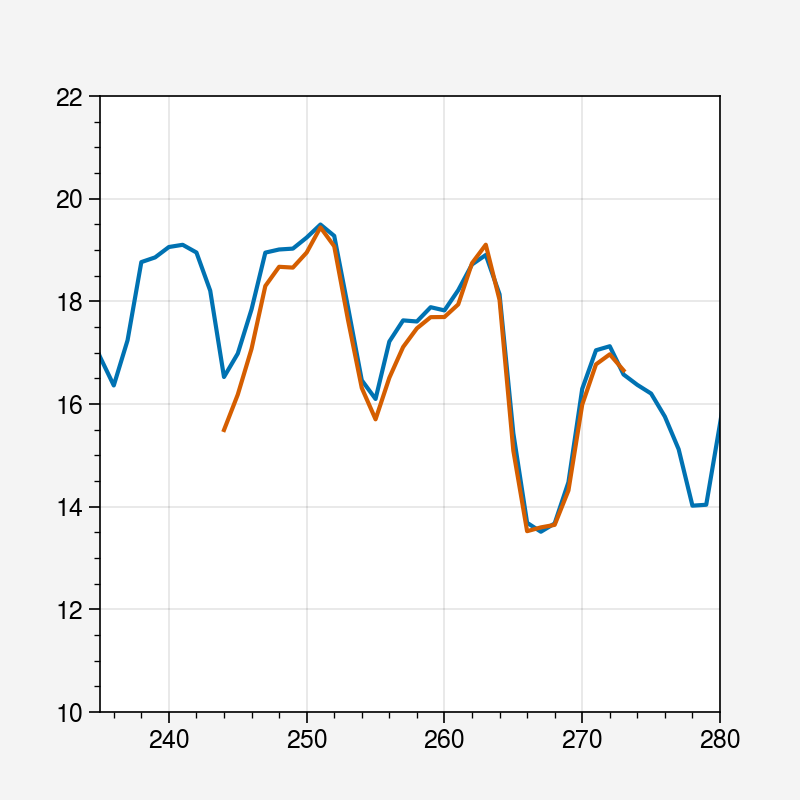

In [7]:
# 31+28+31+30+31+30+31+31 = 243 so 244 is first day of september

plt.plot(np.arange(1,366,1),ds_T_normal.TTz.isel(ztqlev=0).mean(axis=(1,2)))
plt.plot(np.arange(244,274,1),ds_T_test_v314.TTz.isel(ztqlev=0).mean(axis=(1,2)))
plt.xlim((235,280))
plt.ylim((10,22))

/home/castelli/miniforge3/envs/phd_v1/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/castelli/miniforge3/envs/phd_v1/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "


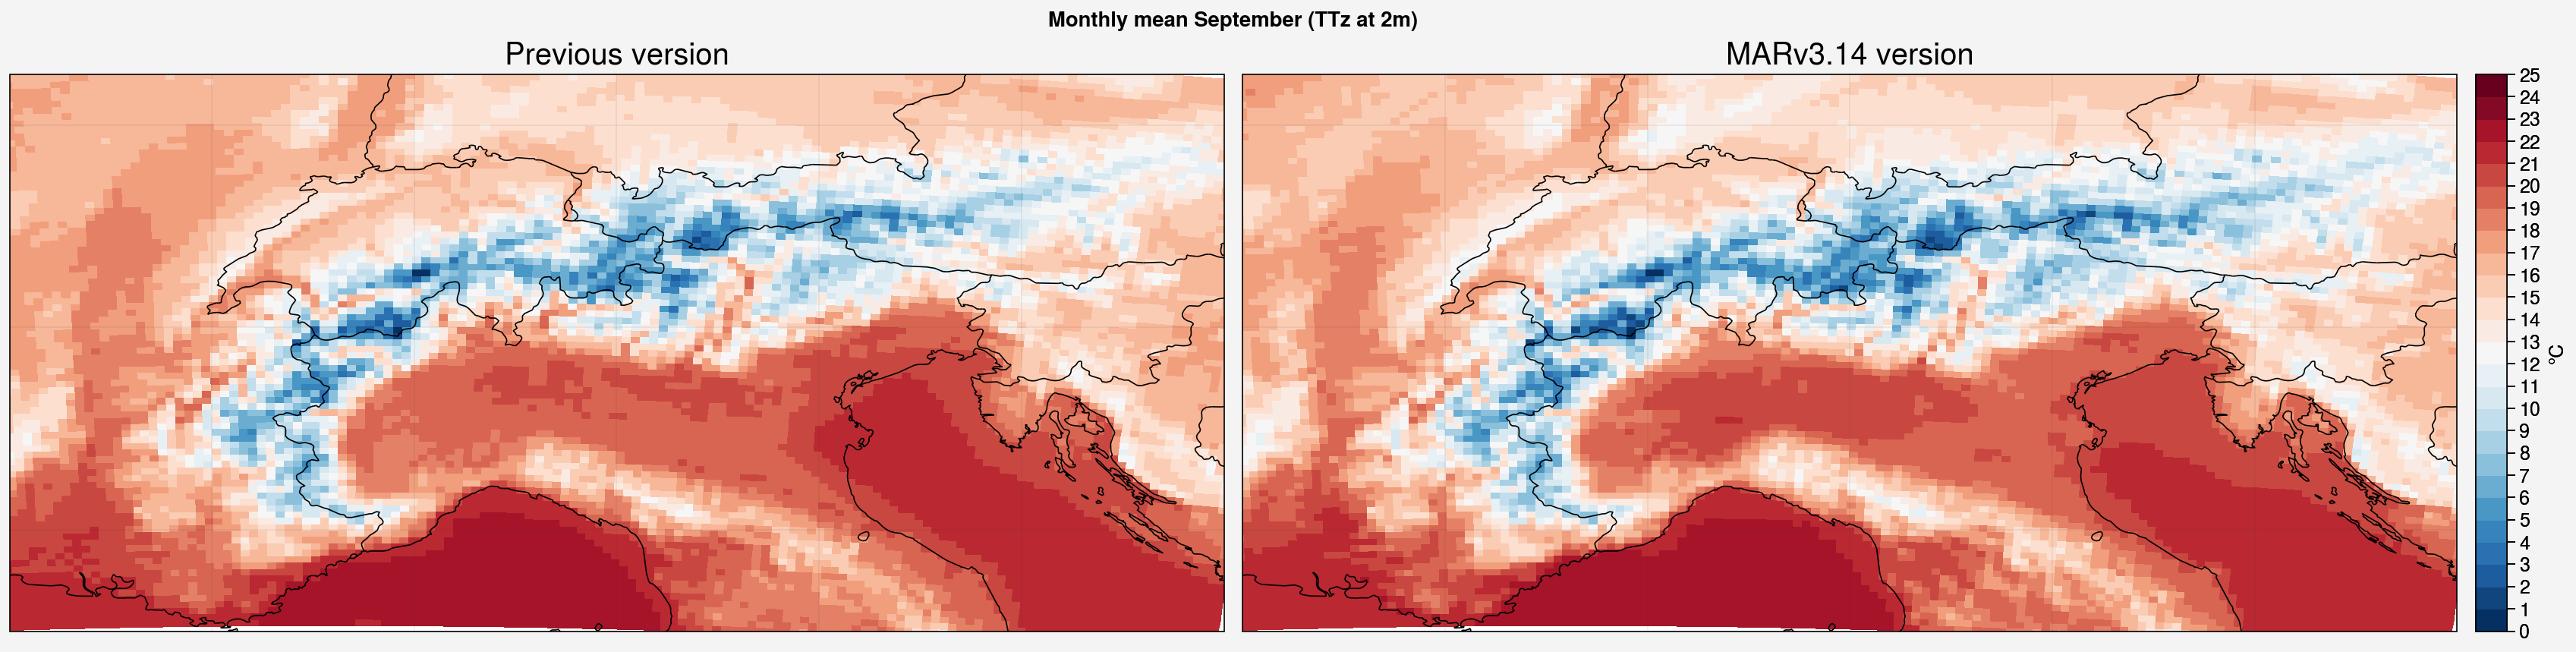

In [8]:
f, axs = pplt.subplots(proj='cyl',axwidth=8,ncols=2)


m = axs[0].pcolormesh(lon,lat,ds_T_normal.TTz.isel(ztqlev=0)[244:274,jmin:jmax,imin:imax].mean(axis=0),
                  levels=np.linspace(0,25,26),cmap='RdBu_r')
axs[0].format(title='Previous version',titlesize='20px')

m = axs[1].pcolormesh(lon,lat,ds_T_test_v314.TTz.isel(ztqlev=0)[:,jmin:jmax,imin:imax].mean(axis=0),
                  levels=np.linspace(0,25,26),cmap='RdBu_r')
axs[1].format(title='MARv3.14 version',titlesize='20px')
f.colorbar(m, label= '°C')

axs.format(**multiplot_format,suptitle="Monthly mean September (TTz at 2m)")

/home/castelli/miniforge3/envs/phd_v1/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "


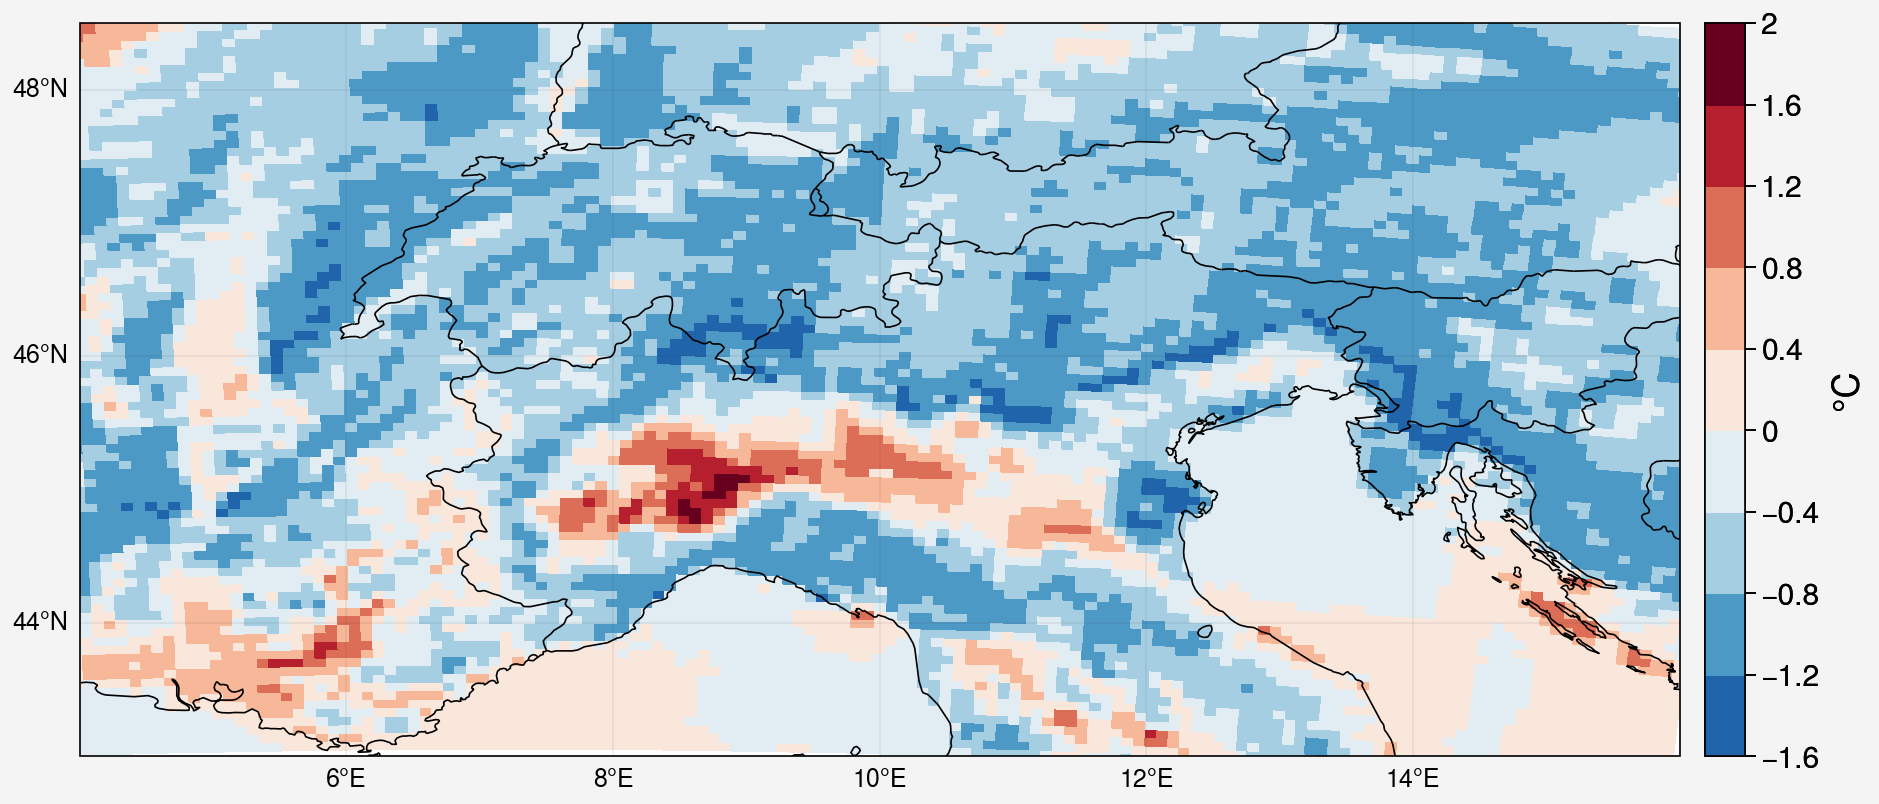

In [9]:
diff_2versions = np.array(ds_T_test_v314.TTz.isel(ztqlev=0)[:,jmin:jmax,imin:imax].
                          mean(axis=0)) - np.array(ds_T_normal.TTz.isel(ztqlev=0)[244:274,jmin:jmax,imin:imax].mean(axis=0))

f, ax = pplt.subplots(proj='cyl', axwidth=8)
m=ax.pcolormesh(lon, lat, diff_2versions, levels=10,cmap='RdBu_r')
f.colorbar(m,label= '°C',labelsize='x-large',ticklabelsize='large')

ax.format(**normal_format)

#### Config b : January

In [10]:
ds_T_test_v314_Jan = xr.open_dataset('/bettik/castelli/data/MAR3.14/MAR-ERA5/testrun_1month/ICE.ERA5.EUb.TTz.01.2014.nc')
ds_T_test_v314_Jan

<xarray.Dataset>
Dimensions:  (time: 31, ztqlev: 3, y: 126, x: 201)
Coordinates:
  * time     (time) datetime64[ns] 2014-01-01T12:00:00 ... 2014-01-31T12:00:00
  * x        (x) float32 -483.0 -476.0 -469.0 -462.0 ... 896.0 903.0 910.0 917.0
  * y        (y) float32 -308.0 -301.0 -294.0 -287.0 ... 546.0 553.0 560.0 567.0
  * ztqlev   (ztqlev) float32 2.0 10.0 100.0
Data variables:
    TTz      (time, ztqlev, y, x) float32 ...
Attributes:
    title:        ICE - Exp: b01 - 20140101
    institution:  ULg (Xavier Fettweis)
    history:      Wed Feb 21 15:08:51 2024: ncks -v TTz /bettik/castelli/MARo...
    netcdf:       4.8.0 of May  2 2023 12:43:48 $
    NCO:          netCDF Operators version 5.0.6 (Homepage = http://nco.sf.ne...

(0.0, 10.0)

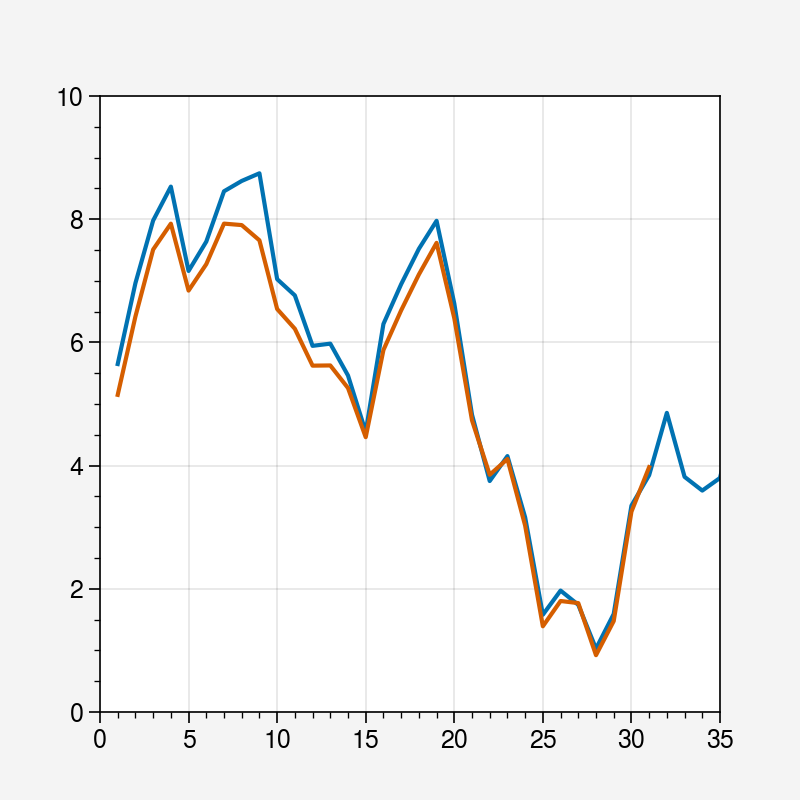

In [11]:
plt.plot(np.arange(1,366,1),ds_T_normal.TTz.isel(ztqlev=0).mean(axis=(1,2)))
plt.plot(np.arange(1,32,1),ds_T_test_v314_Jan.TTz.isel(ztqlev=0).mean(axis=(1,2)))
plt.xlim((0,35))
plt.ylim((0,10))
#plt.vlines(1,ymin=0,ymax=10)

/home/castelli/miniforge3/envs/phd_v1/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "


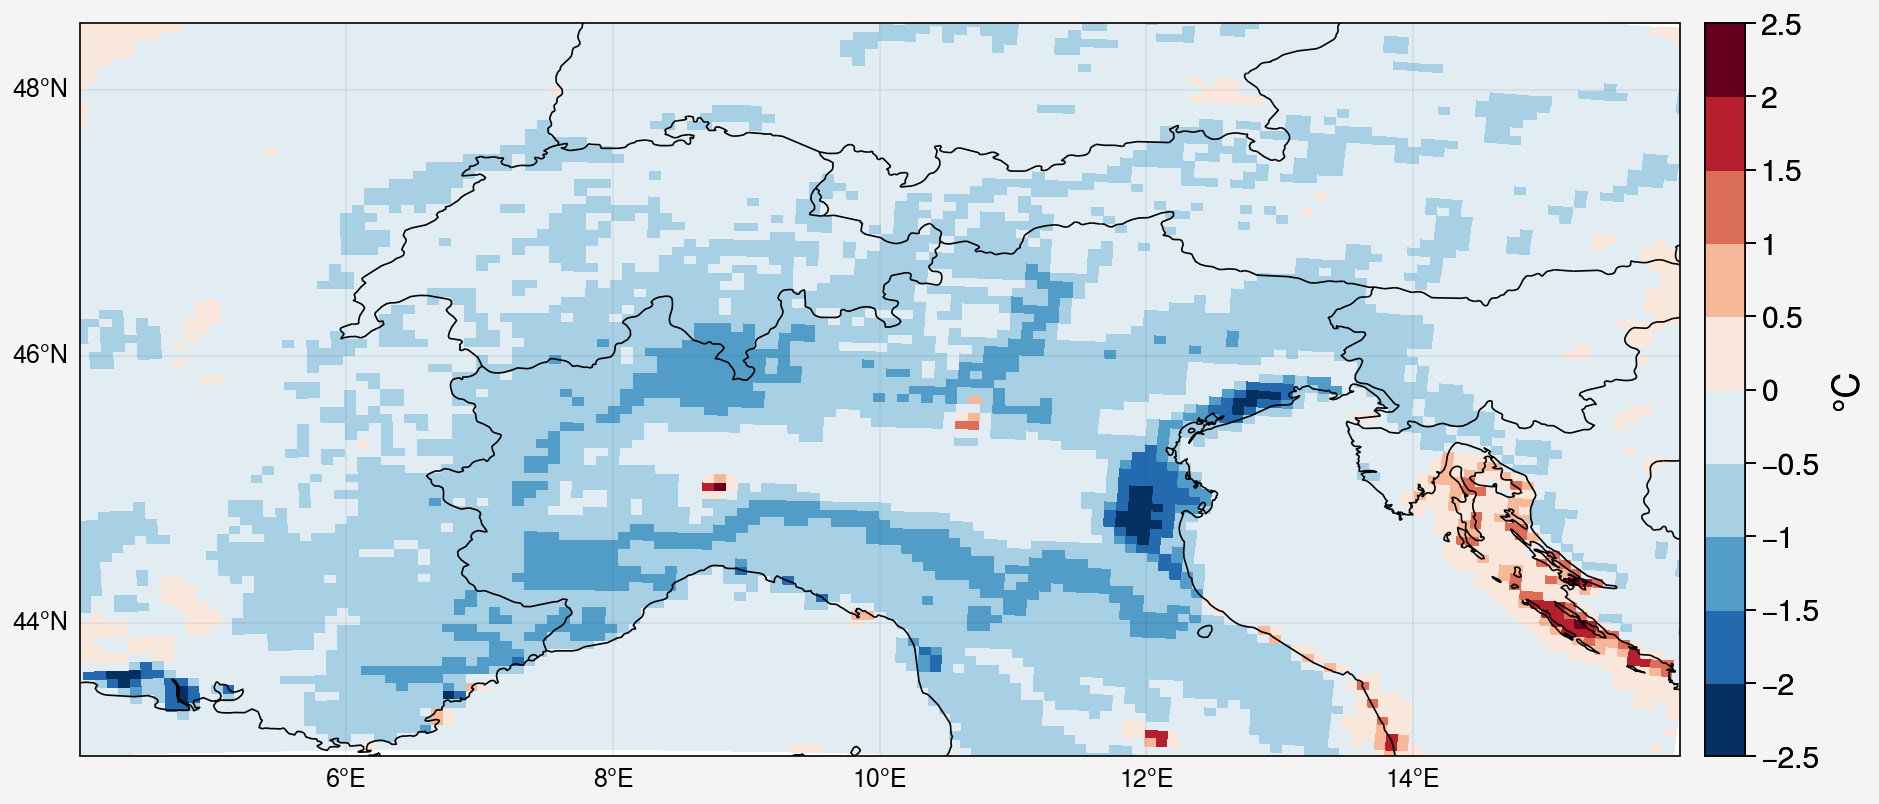

In [12]:
diff_2versions = np.array(ds_T_test_v314_Jan.TTz.isel(ztqlev=0)[:,jmin:jmax,imin:imax].
                          mean(axis=0)) - np.array(ds_T_normal.TTz.isel(ztqlev=0)[0:31,jmin:jmax,imin:imax].mean(axis=0))

f, ax = pplt.subplots(proj='cyl', axwidth=8)
m=ax.pcolormesh(lon, lat, diff_2versions, levels=10,cmap='RdBu_r')
f.colorbar(m,label= '°C',labelsize='x-large',ticklabelsize='large')

ax.format(**normal_format)

In [13]:
diff_2versions.min()

-2.3039255

### EUb 2014-2016

In [14]:
# Don't take 2014 as it is spin-up year

ds_T_test_v314_2015 = xr.open_dataset('/bettik/castelli/data/MAR3.14/MAR-ERA5/EUb/ICE.ERA5.EUb.TTz.2015.nc')
ds_T_test_v314_2016 = xr.open_dataset('/bettik/castelli/data/MAR3.14/MAR-ERA5/EUb/ICE.ERA5.EUb.TTz.2016.nc')

ds_T_normal_2015 = xr.open_dataset('/bettik/beaumetj/MARout/MAR-ERA5/daily/ICE.ERA5_v1.EUl.TTz.2015.nc')
ds_T_normal_2016 = xr.open_dataset('/bettik/beaumetj/MARout/MAR-ERA5/daily/ICE.ERA5_v1.EUl.TTz.2016.nc')


ds_QQz_test_v314_2015 = xr.open_dataset('/bettik/castelli/data/MAR3.14/MAR-ERA5/EUb/ICE.ERA5.EUb.QQz.2015.nc')
ds_QQz_test_v314_2016 = xr.open_dataset('/bettik/castelli/data/MAR3.14/MAR-ERA5/EUb/ICE.ERA5.EUb.QQz.2016.nc')

ds_QQz_normal_2015 = xr.open_dataset('/bettik/beaumetj/MARout/MAR-ERA5/daily/ICE.ERA5_v1.EUl.QQz.2015.nc')
ds_QQz_normal_2016 = xr.open_dataset('/bettik/beaumetj/MARout/MAR-ERA5/daily/ICE.ERA5_v1.EUl.QQz.2016.nc')


ds_RR_test_v314_2015 = xr.open_dataset('/bettik/castelli/data/MAR3.14/MAR-ERA5/EUb/ICE.ERA5.EUb.MBrr.2015.nc')
ds_RR_test_v314_2016 = xr.open_dataset('/bettik/castelli/data/MAR3.14/MAR-ERA5/EUb/ICE.ERA5.EUb.MBrr.2016.nc')

ds_RR_normal_2015 = xr.open_dataset('/bettik/beaumetj/MARout/MAR-ERA5/daily/ICE.ERA5_v1.EUl.MBrr.2015.nc')
ds_RR_normal_2016 = xr.open_dataset('/bettik/beaumetj/MARout/MAR-ERA5/daily/ICE.ERA5_v1.EUl.MBrr.2016.nc')

ds_SF_test_v314_2015 = xr.open_dataset('/bettik/castelli/data/MAR3.14/MAR-ERA5/EUb/ICE.ERA5.EUb.MBsf.2015.nc')
ds_SF_test_v314_2016 = xr.open_dataset('/bettik/castelli/data/MAR3.14/MAR-ERA5/EUb/ICE.ERA5.EUb.MBsf.2016.nc')

ds_SF_normal_2015 = xr.open_dataset('/bettik/beaumetj/MARout/MAR-ERA5/daily/ICE.ERA5_v1.EUl.MBsf.2015.nc')
ds_SF_normal_2016 = xr.open_dataset('/bettik/beaumetj/MARout/MAR-ERA5/daily/ICE.ERA5_v1.EUl.MBsf.2016.nc')

In [15]:
Tdiff_2015 = np.array(ds_T_test_v314_2015.TTz.isel(ztqlev=0)[:,jmin:jmax,imin:imax]) - np.array(ds_T_normal_2015.TTz.isel(ztqlev=0)[:,jmin:jmax,imin:imax])
Tdiff_2016 = np.array(ds_T_test_v314_2016.TTz.isel(ztqlev=0)[:,jmin:jmax,imin:imax]) - np.array(ds_T_normal_2016.TTz.isel(ztqlev=0)[:,jmin:jmax,imin:imax])

print(Tdiff_2015.max(),Tdiff_2015.min())
print(Tdiff_2016.max(),Tdiff_2016.min())

8.337653 -8.868603
9.886993 -10.036758


In [16]:
QQzdiff_2015 = np.array(ds_QQz_test_v314_2015.QQz.isel(ztqlev=0)[:,jmin:jmax,imin:imax]) - np.array(ds_QQz_normal_2015.QQz.isel(ztqlev=0)[:,jmin:jmax,imin:imax])
QQzdiff_2016 = np.array(ds_QQz_test_v314_2016.QQz.isel(ztqlev=0)[:,jmin:jmax,imin:imax]) - np.array(ds_QQz_normal_2016.QQz.isel(ztqlev=0)[:,jmin:jmax,imin:imax])

print(QQzdiff_2015.max(),QQzdiff_2015.min())
print(QQzdiff_2016.max(),QQzdiff_2016.min())

3.8473644 -5.8789616
4.5175695 -4.486166


In [30]:
# TP : Total Precip

ds_TP_test_v314_2015 = ds_RR_test_v314_2015.MBrr[:,jmin:jmax,imin:imax] + ds_SF_test_v314_2015.MBsf[:,jmin:jmax,imin:imax]
ds_TP_test_v314_2016 = ds_RR_test_v314_2016.MBrr[:,jmin:jmax,imin:imax] + ds_SF_test_v314_2016.MBsf[:,jmin:jmax,imin:imax]

ds_TP_normal_2015 = ds_RR_normal_2015.MBrr[:,jmin:jmax,imin:imax] + ds_SF_normal_2015.MBsf[:,jmin:jmax,imin:imax]
ds_TP_normal_2016 = ds_RR_normal_2016.MBrr[:,jmin:jmax,imin:imax] + ds_SF_normal_2016.MBsf[:,jmin:jmax,imin:imax]

TPdiff_2015 = np.array(ds_TP_test_v314_2015) - np.array(ds_TP_normal_2015)
TPdiff_2016 = np.array(ds_TP_test_v314_2016) - np.array(ds_TP_normal_2016)

print(TPdiff_2015.max(),TPdiff_2015.min())
print(TPdiff_2016.max(),TPdiff_2016.min())


56.400917 -115.78394
88.24318 -189.9287


/home/castelli/miniforge3/envs/phd_v1/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/castelli/miniforge3/envs/phd_v1/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/castelli/miniforge3/envs/phd_v1/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/castelli/miniforge3/envs/phd_v1/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to ins

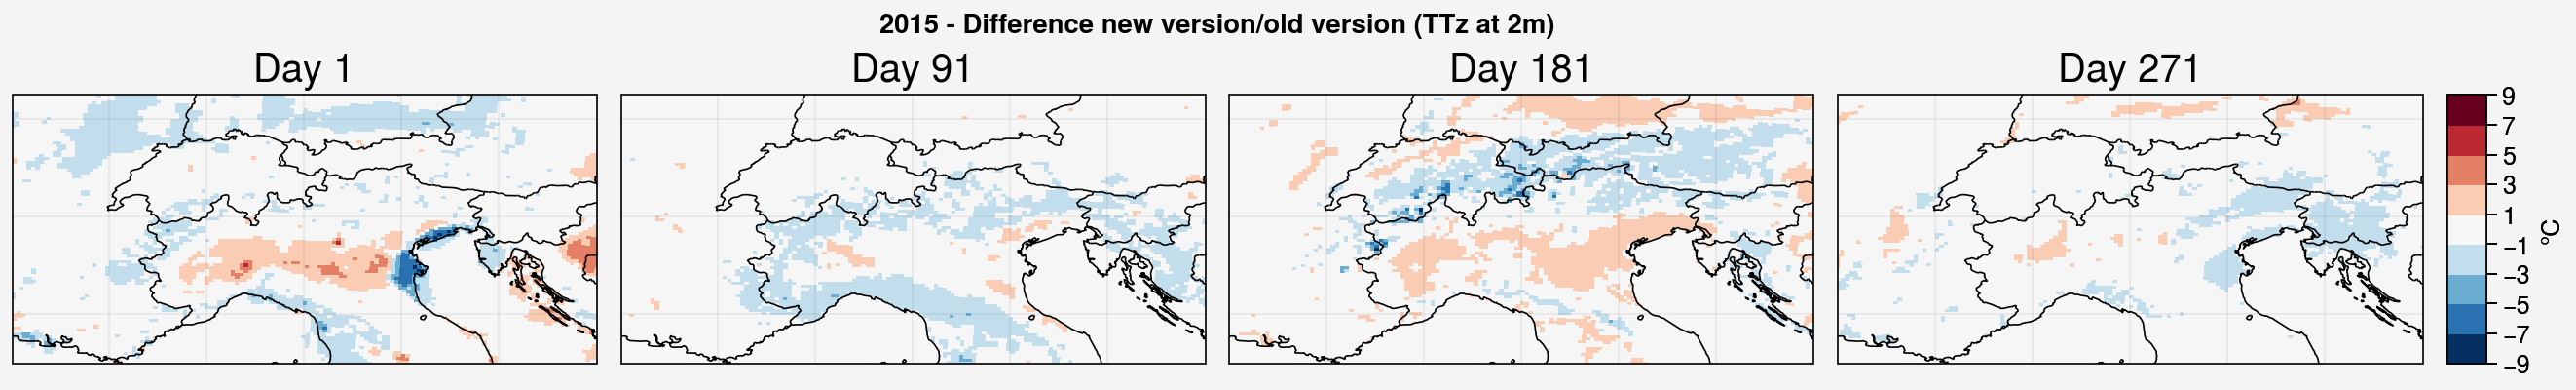

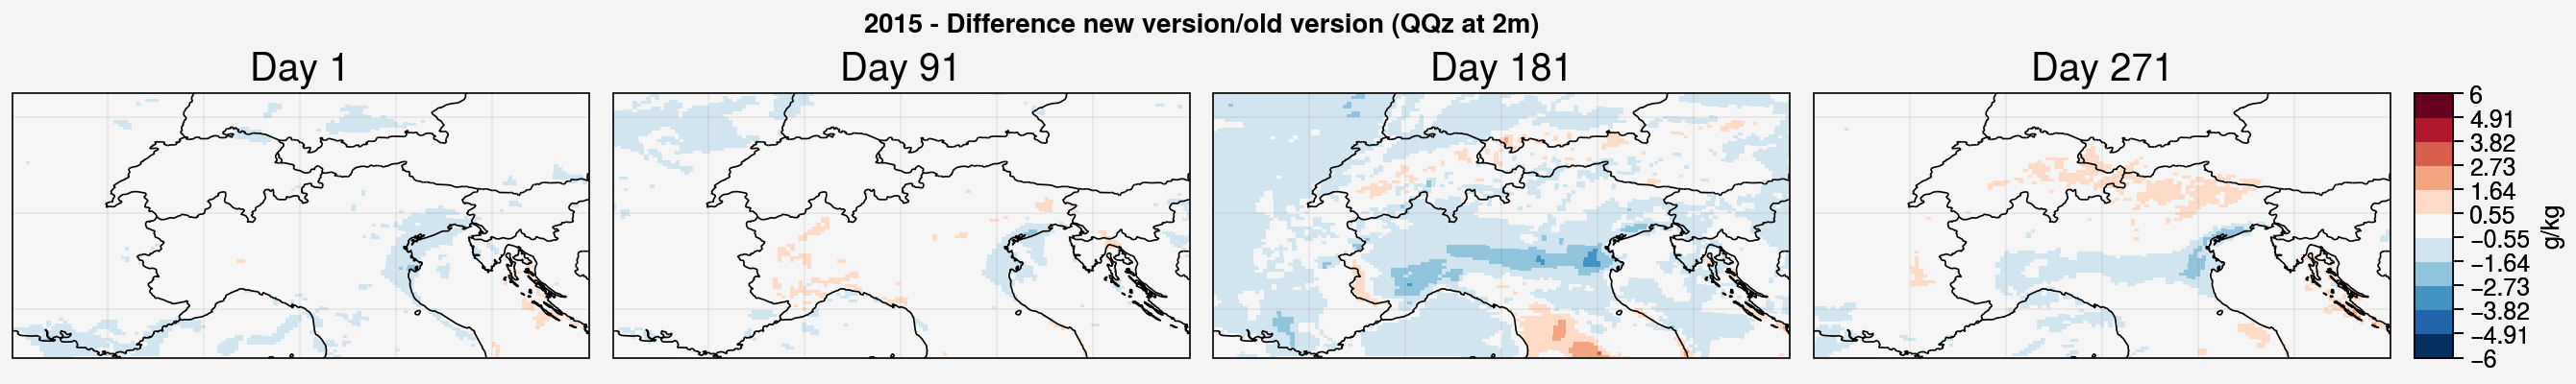

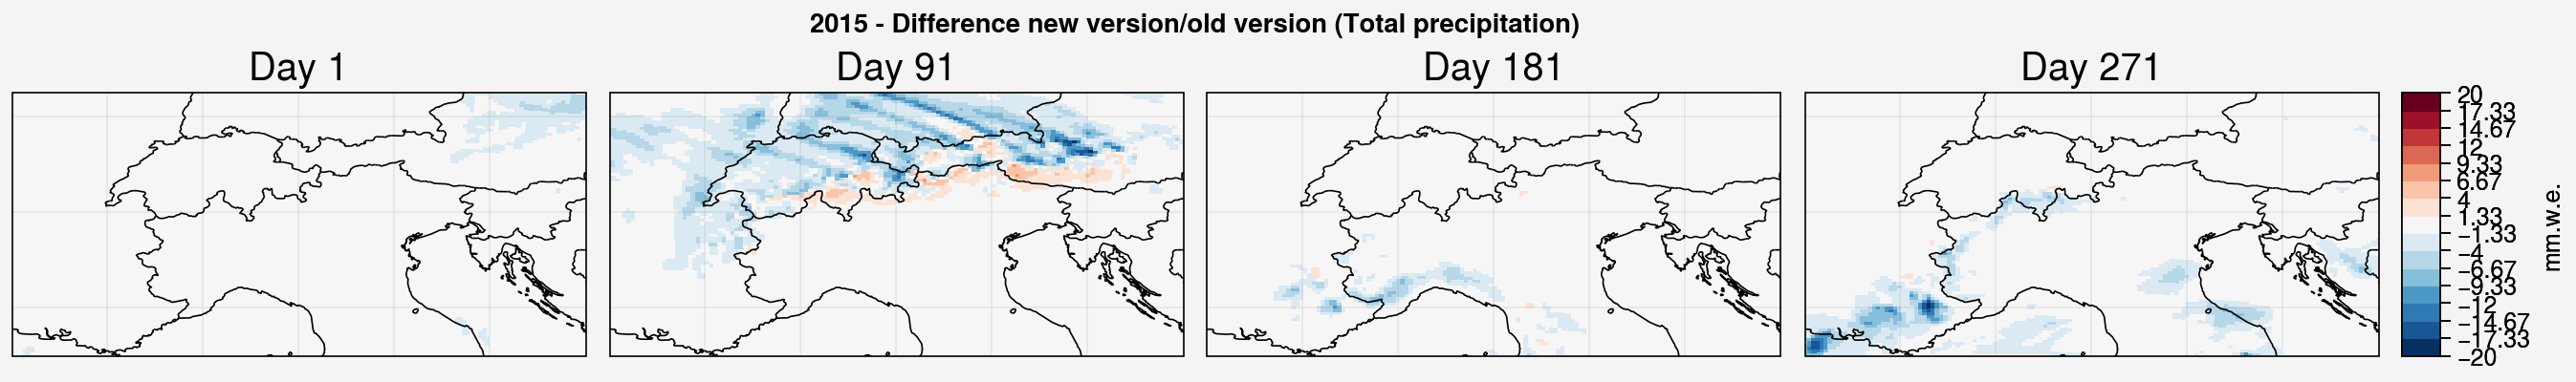

In [33]:
f, axs = pplt.subplots(proj='cyl',axwidth=3,ncols=4)

m = axs[0].pcolormesh(lon,lat,Tdiff_2015[0],levels=np.linspace(-9,9,10),cmap='RdBu_r')
axs[0].format(title='Day 1',titlesize='20px')

m = axs[1].pcolormesh(lon,lat,Tdiff_2015[90],levels=np.linspace(-9,9,10),cmap='RdBu_r')
axs[1].format(title='Day 91',titlesize='20px')

m = axs[2].pcolormesh(lon,lat,Tdiff_2015[180],levels=np.linspace(-9,9,10),cmap='RdBu_r')
axs[2].format(title='Day 181',titlesize='20px')

m = axs[3].pcolormesh(lon,lat,Tdiff_2015[270],levels=np.linspace(-9,9,10),cmap='RdBu_r')
axs[3].format(title='Day 271',titlesize='20px')
f.colorbar(m, label= '°C')

axs.format(**multiplot_format,suptitle="2015 - Difference new version/old version (TTz at 2m)")


f, axs = pplt.subplots(proj='cyl',axwidth=3,ncols=4)

m = axs[0].pcolormesh(lon,lat,QQzdiff_2015[0],levels=np.linspace(-6,6,12),cmap='RdBu_r')
axs[0].format(title='Day 1',titlesize='20px')

m = axs[1].pcolormesh(lon,lat,QQzdiff_2015[90],levels=np.linspace(-6,6,12),cmap='RdBu_r')
axs[1].format(title='Day 91',titlesize='20px')

m = axs[2].pcolormesh(lon,lat,QQzdiff_2015[180],levels=np.linspace(-6,6,12),cmap='RdBu_r')
axs[2].format(title='Day 181',titlesize='20px')

m = axs[3].pcolormesh(lon,lat,QQzdiff_2015[270],levels=np.linspace(-6,6,12),cmap='RdBu_r')
axs[3].format(title='Day 271',titlesize='20px')
f.colorbar(m, label= 'g/kg')

axs.format(**multiplot_format,suptitle="2015 - Difference new version/old version (QQz at 2m)")


f, axs = pplt.subplots(proj='cyl',axwidth=3,ncols=4)

m = axs[0].pcolormesh(lon,lat,TPdiff_2015[0],levels=np.linspace(-20,20,16),cmap='RdBu_r')
axs[0].format(title='Day 1',titlesize='20px')

m = axs[1].pcolormesh(lon,lat,TPdiff_2015[90],levels=np.linspace(-20,20,16),cmap='RdBu_r')
axs[1].format(title='Day 91',titlesize='20px')

m = axs[2].pcolormesh(lon,lat,TPdiff_2015[180],levels=np.linspace(-20,20,16),cmap='RdBu_r')
axs[2].format(title='Day 181',titlesize='20px')

m = axs[3].pcolormesh(lon,lat,TPdiff_2015[270],levels=np.linspace(-20,20,16),cmap='RdBu_r')
axs[3].format(title='Day 271',titlesize='20px')
f.colorbar(m, label= 'mm.w.e.')

axs.format(**multiplot_format,suptitle="2015 - Difference new version/old version (Total precipitation)")

/home/castelli/miniforge3/envs/phd_v1/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/castelli/miniforge3/envs/phd_v1/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/castelli/miniforge3/envs/phd_v1/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/castelli/miniforge3/envs/phd_v1/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to ins

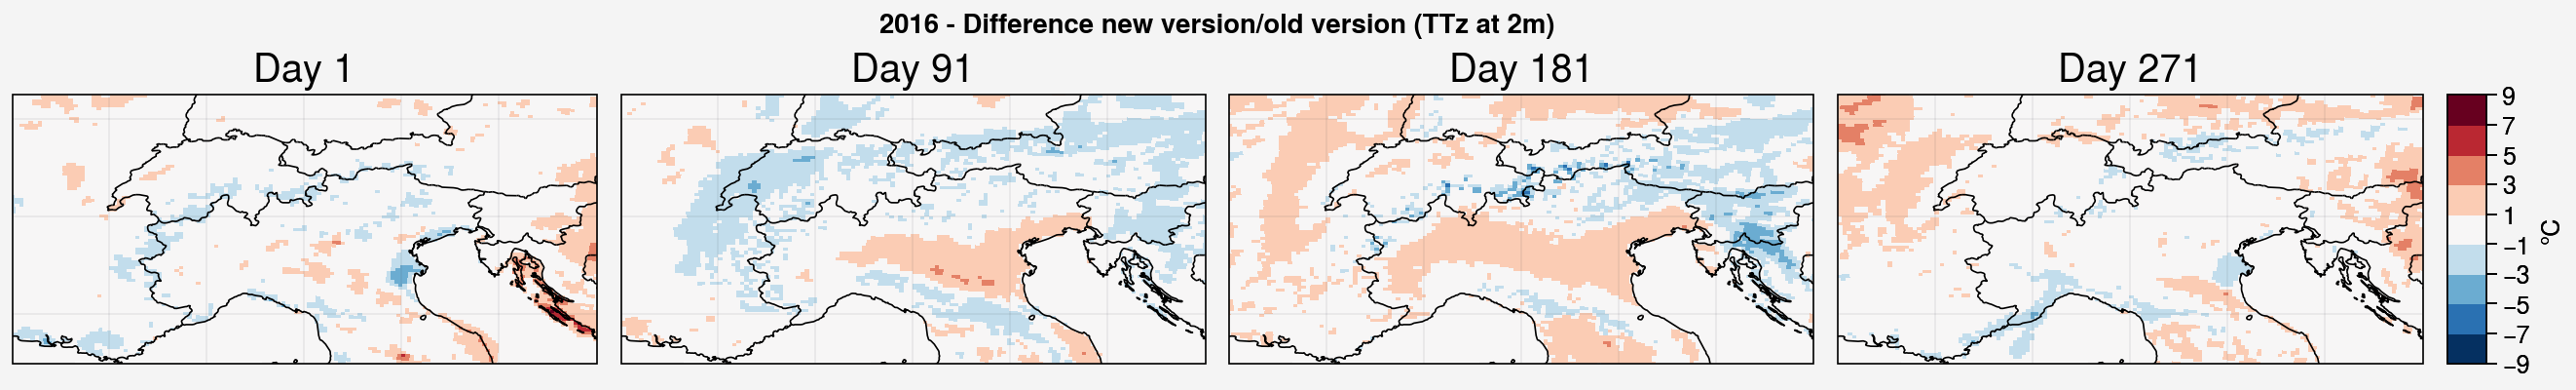

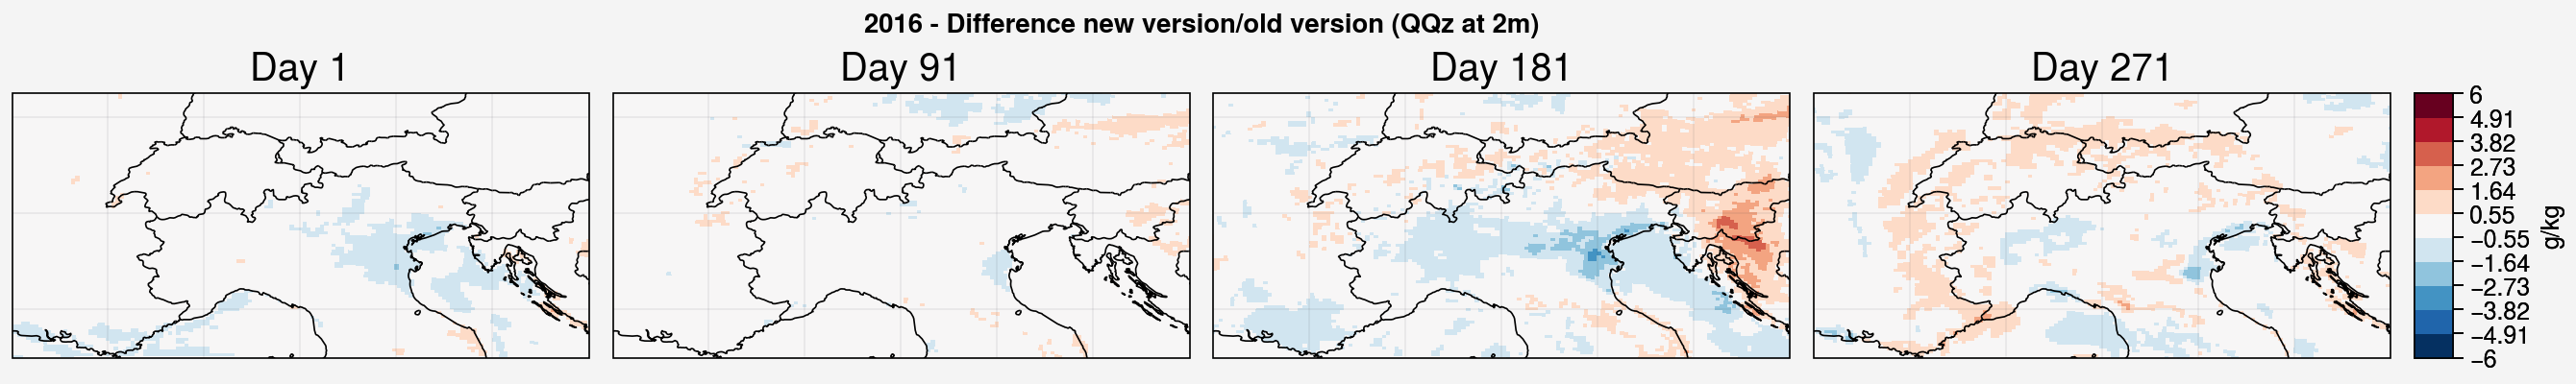

In [19]:
f, axs = pplt.subplots(proj='cyl',axwidth=3,ncols=4)

m = axs[0].pcolormesh(lon,lat,Tdiff_2016[0],levels=np.linspace(-9,9,10),cmap='RdBu_r')
axs[0].format(title='Day 1',titlesize='20px')

m = axs[1].pcolormesh(lon,lat,Tdiff_2016[90],levels=np.linspace(-9,9,10),cmap='RdBu_r')
axs[1].format(title='Day 91',titlesize='20px')

m = axs[2].pcolormesh(lon,lat,Tdiff_2016[180],levels=np.linspace(-9,9,10),cmap='RdBu_r')
axs[2].format(title='Day 181',titlesize='20px')

m = axs[3].pcolormesh(lon,lat,Tdiff_2016[270],levels=np.linspace(-9,9,10),cmap='RdBu_r')
axs[3].format(title='Day 271',titlesize='20px')
f.colorbar(m, label= '°C')

axs.format(**multiplot_format,suptitle="2016 - Difference new version/old version (TTz at 2m)")


f, axs = pplt.subplots(proj='cyl',axwidth=3,ncols=4)

m = axs[0].pcolormesh(lon,lat,QQzdiff_2016[0],levels=np.linspace(-6,6,12),cmap='RdBu_r')
axs[0].format(title='Day 1',titlesize='20px')

m = axs[1].pcolormesh(lon,lat,QQzdiff_2016[90],levels=np.linspace(-6,6,12),cmap='RdBu_r')
axs[1].format(title='Day 91',titlesize='20px')

m = axs[2].pcolormesh(lon,lat,QQzdiff_2016[180],levels=np.linspace(-6,6,12),cmap='RdBu_r')
axs[2].format(title='Day 181',titlesize='20px')

m = axs[3].pcolormesh(lon,lat,QQzdiff_2016[270],levels=np.linspace(-6,6,12),cmap='RdBu_r')
axs[3].format(title='Day 271',titlesize='20px')
f.colorbar(m, label= 'g/kg')

axs.format(**multiplot_format,suptitle="2016 - Difference new version/old version (QQz at 2m)")

/home/castelli/miniforge3/envs/phd_v1/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/castelli/miniforge3/envs/phd_v1/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/castelli/miniforge3/envs/phd_v1/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/castelli/miniforge3/envs/phd_v1/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to ins

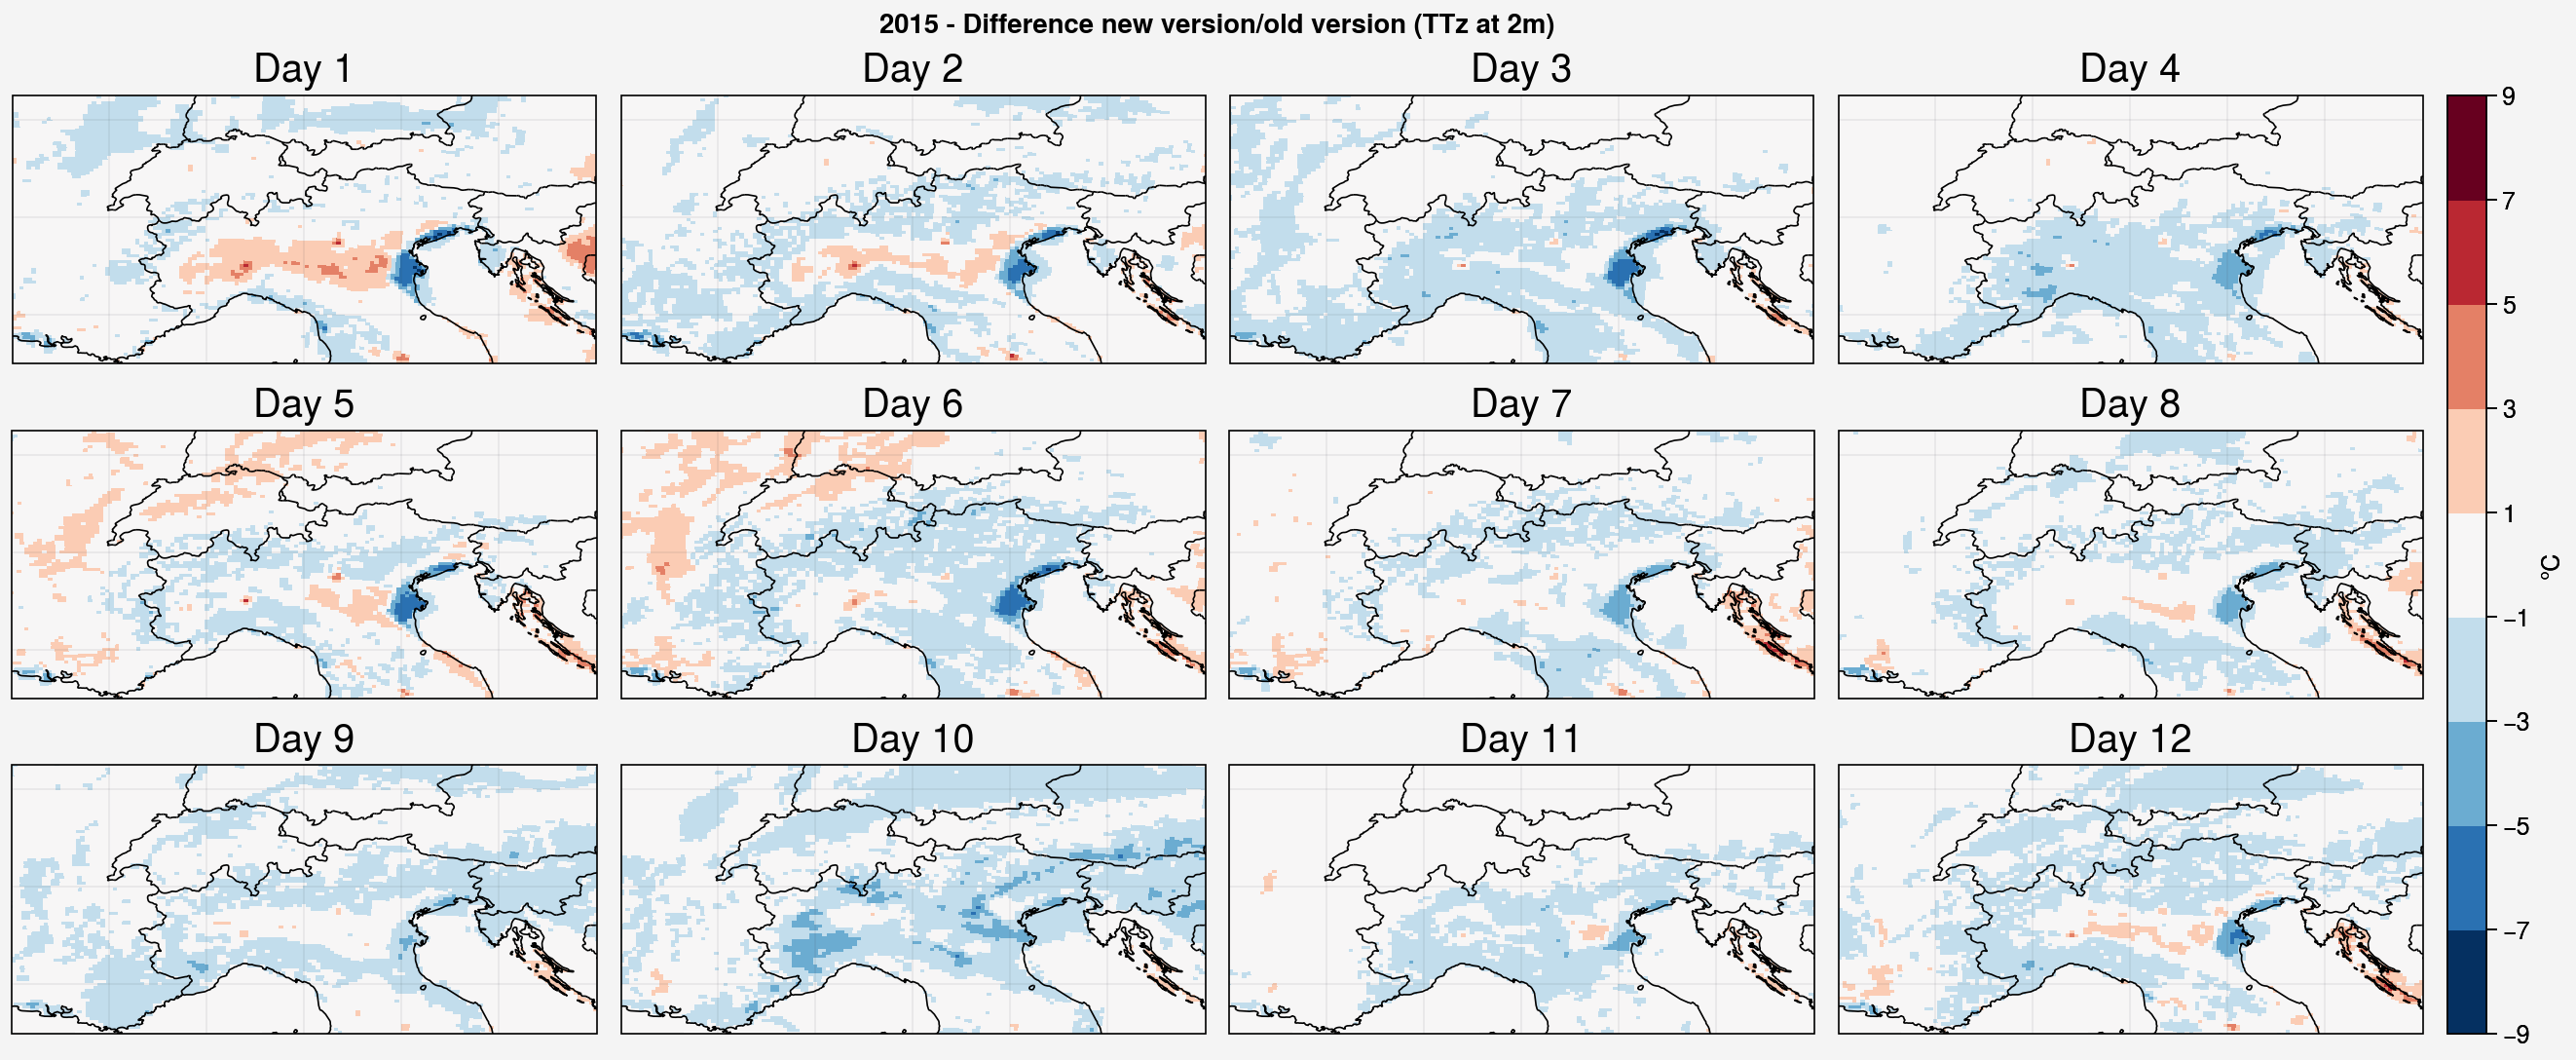

In [20]:
f, axs = pplt.subplots(proj='cyl',axwidth=3,ncols=4,nrows=3)

for day in range(12):
    m = axs[day].pcolormesh(lon,lat,Tdiff_2015[day],levels=np.linspace(-9,9,10),cmap='RdBu_r')
    axs[day].format(title=f'Day {day+1}',titlesize='20px')

f.colorbar(m, label= '°C')

axs.format(**multiplot_format,suptitle="2015 - Difference new version/old version (TTz at 2m)")

In [21]:
# Monthly

monthlyT_diff_2015 = np.array(ds_T_test_v314_2015.TTz.isel(ztqlev=0)[:,jmin:jmax,imin:imax].groupby("time.month").mean("time"))-np.array(ds_T_normal_2015.TTz.isel(ztqlev=0)[:,jmin:jmax,imin:imax].groupby("time.month").mean("time"))
monthlyT_diff_2016 = np.array(ds_T_test_v314_2016.TTz.isel(ztqlev=0)[:,jmin:jmax,imin:imax].groupby("time.month").mean("time")) - np.array(ds_T_normal_2016.TTz.isel(ztqlev=0)[:,jmin:jmax,imin:imax].groupby("time.month").mean("time"))

print(monthlyT_diff_2015.max(),monthlyT_diff_2015.min())
print(monthlyT_diff_2016.max(),monthlyT_diff_2016.min())

4.0083065 -4.2015285
5.0356603 -5.2236395


In [22]:
monthlyQQz_diff_2015 = np.array(ds_QQz_test_v314_2015.QQz.isel(ztqlev=0)[:,jmin:jmax,imin:imax].groupby("time.month").mean("time"))-np.array(ds_QQz_normal_2015.QQz.isel(ztqlev=0)[:,jmin:jmax,imin:imax].groupby("time.month").mean("time"))
monthlyQQz_diff_2016 = np.array(ds_QQz_test_v314_2016.QQz.isel(ztqlev=0)[:,jmin:jmax,imin:imax].groupby("time.month").mean("time")) - np.array(ds_QQz_normal_2016.QQz.isel(ztqlev=0)[:,jmin:jmax,imin:imax].groupby("time.month").mean("time"))

print(monthlyQQz_diff_2015.max(),monthlyQQz_diff_2015.min())
print(monthlyQQz_diff_2016.max(),monthlyQQz_diff_2016.min())

1.8019605 -2.694234
2.164487 -2.7226686


In [35]:
monthlyTP_diff_2015 = np.array(ds_TP_test_v314_2015.groupby("time.month").mean("time")) - np.array(ds_TP_normal_2015.groupby("time.month").mean("time"))
monthlyTP_diff_2016 = np.array(ds_TP_test_v314_2016.groupby("time.month").mean("time")) - np.array(ds_TP_normal_2016.groupby("time.month").mean("time"))

print(monthlyTP_diff_2015.max(),monthlyTP_diff_2015.min())
print(monthlyTP_diff_2016.max(),monthlyTP_diff_2016.min())

3.324004 -11.40173
4.472009 -11.185493


In [23]:
monthlyT_diff_2015.shape

(12, 91, 139)

/home/castelli/miniforge3/envs/phd_v1/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/castelli/miniforge3/envs/phd_v1/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/castelli/miniforge3/envs/phd_v1/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/castelli/miniforge3/envs/phd_v1/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to ins

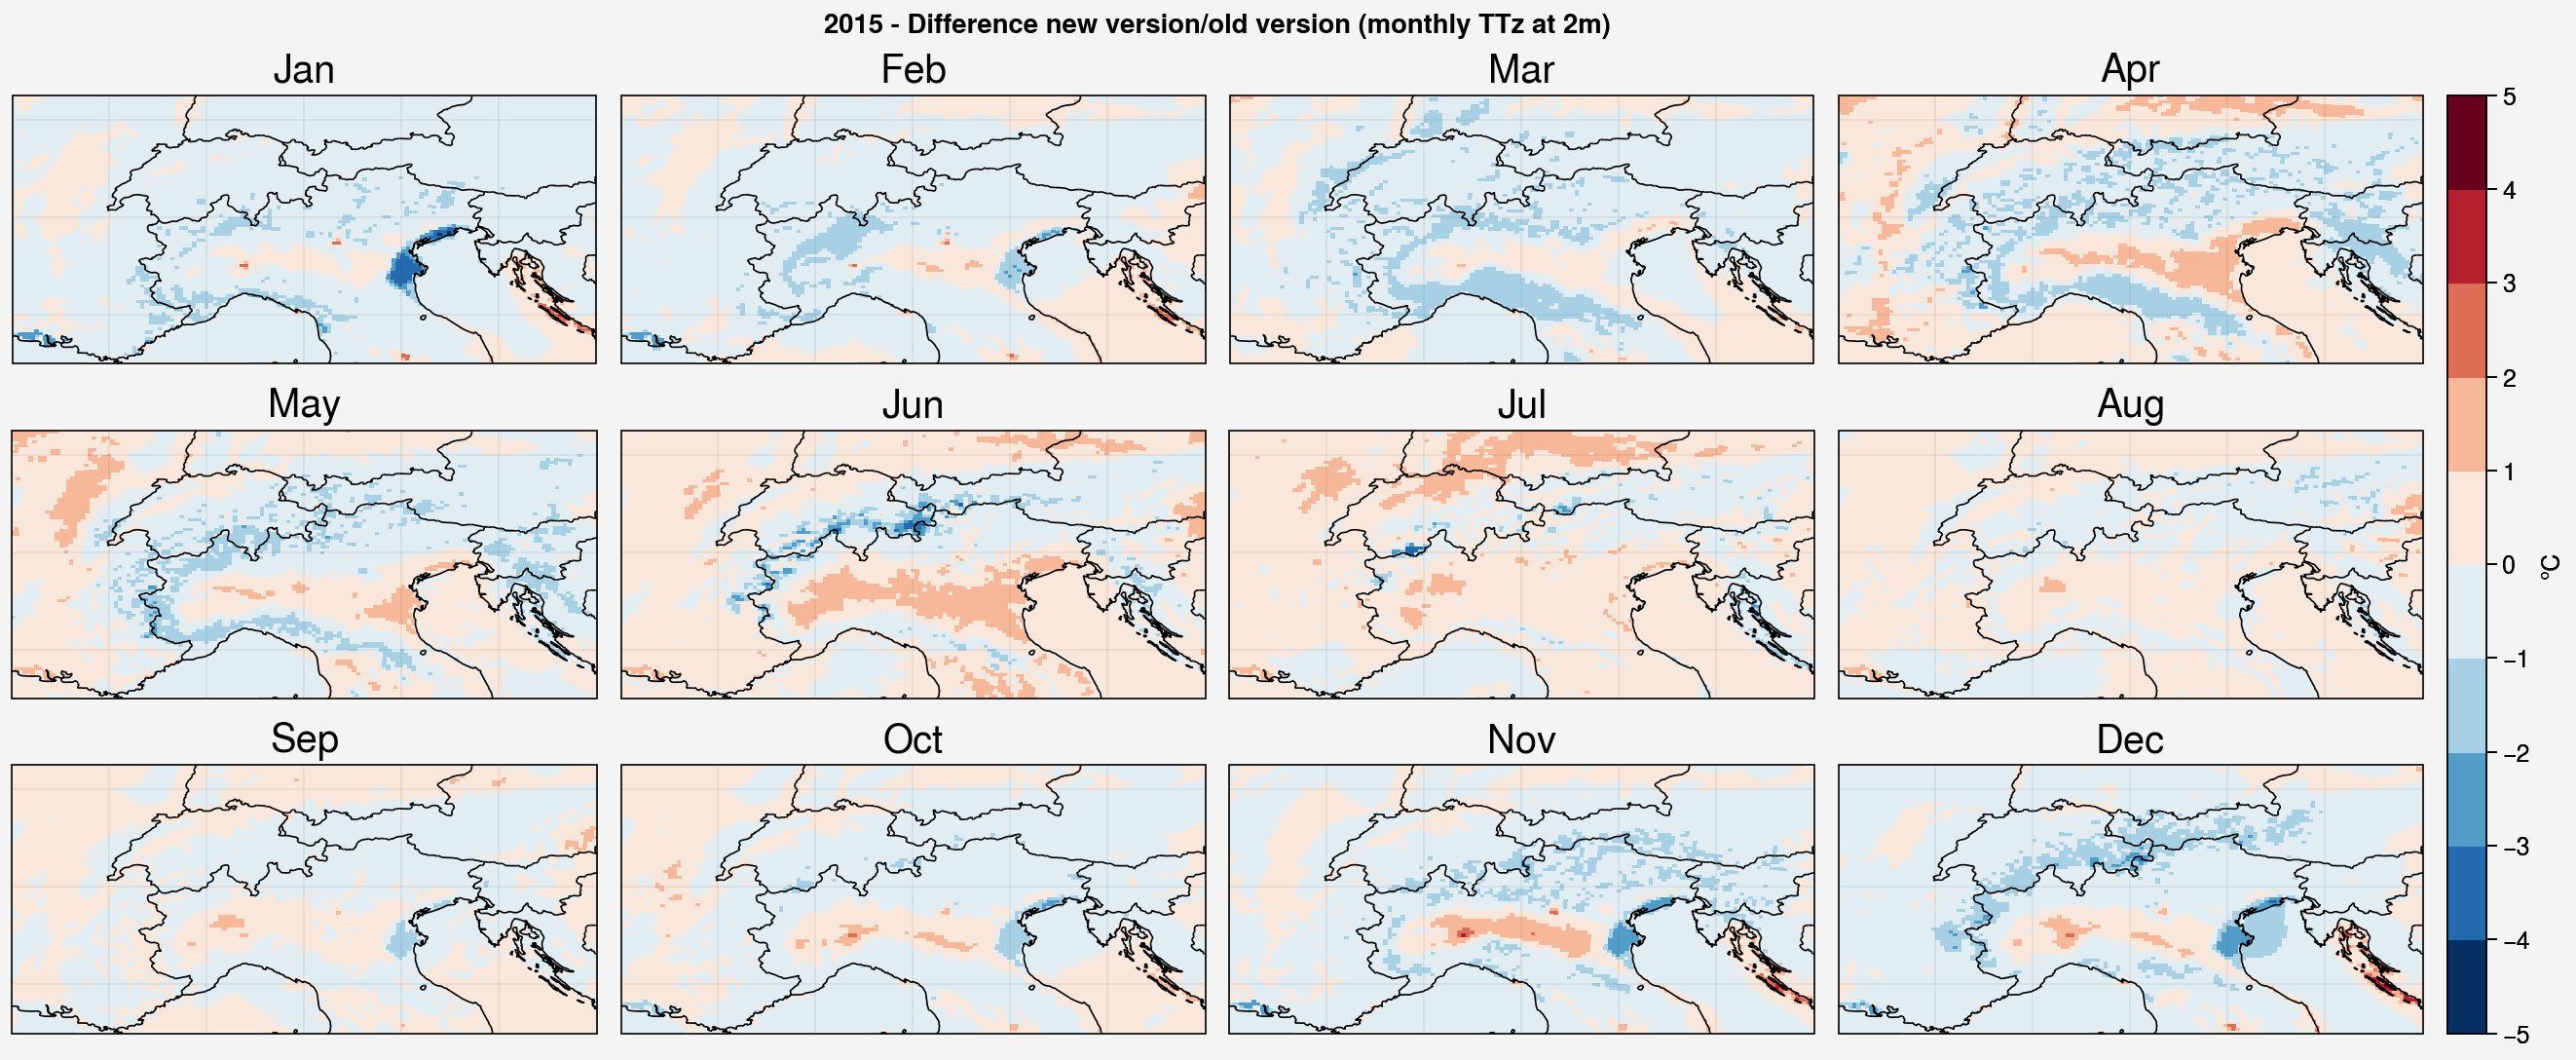

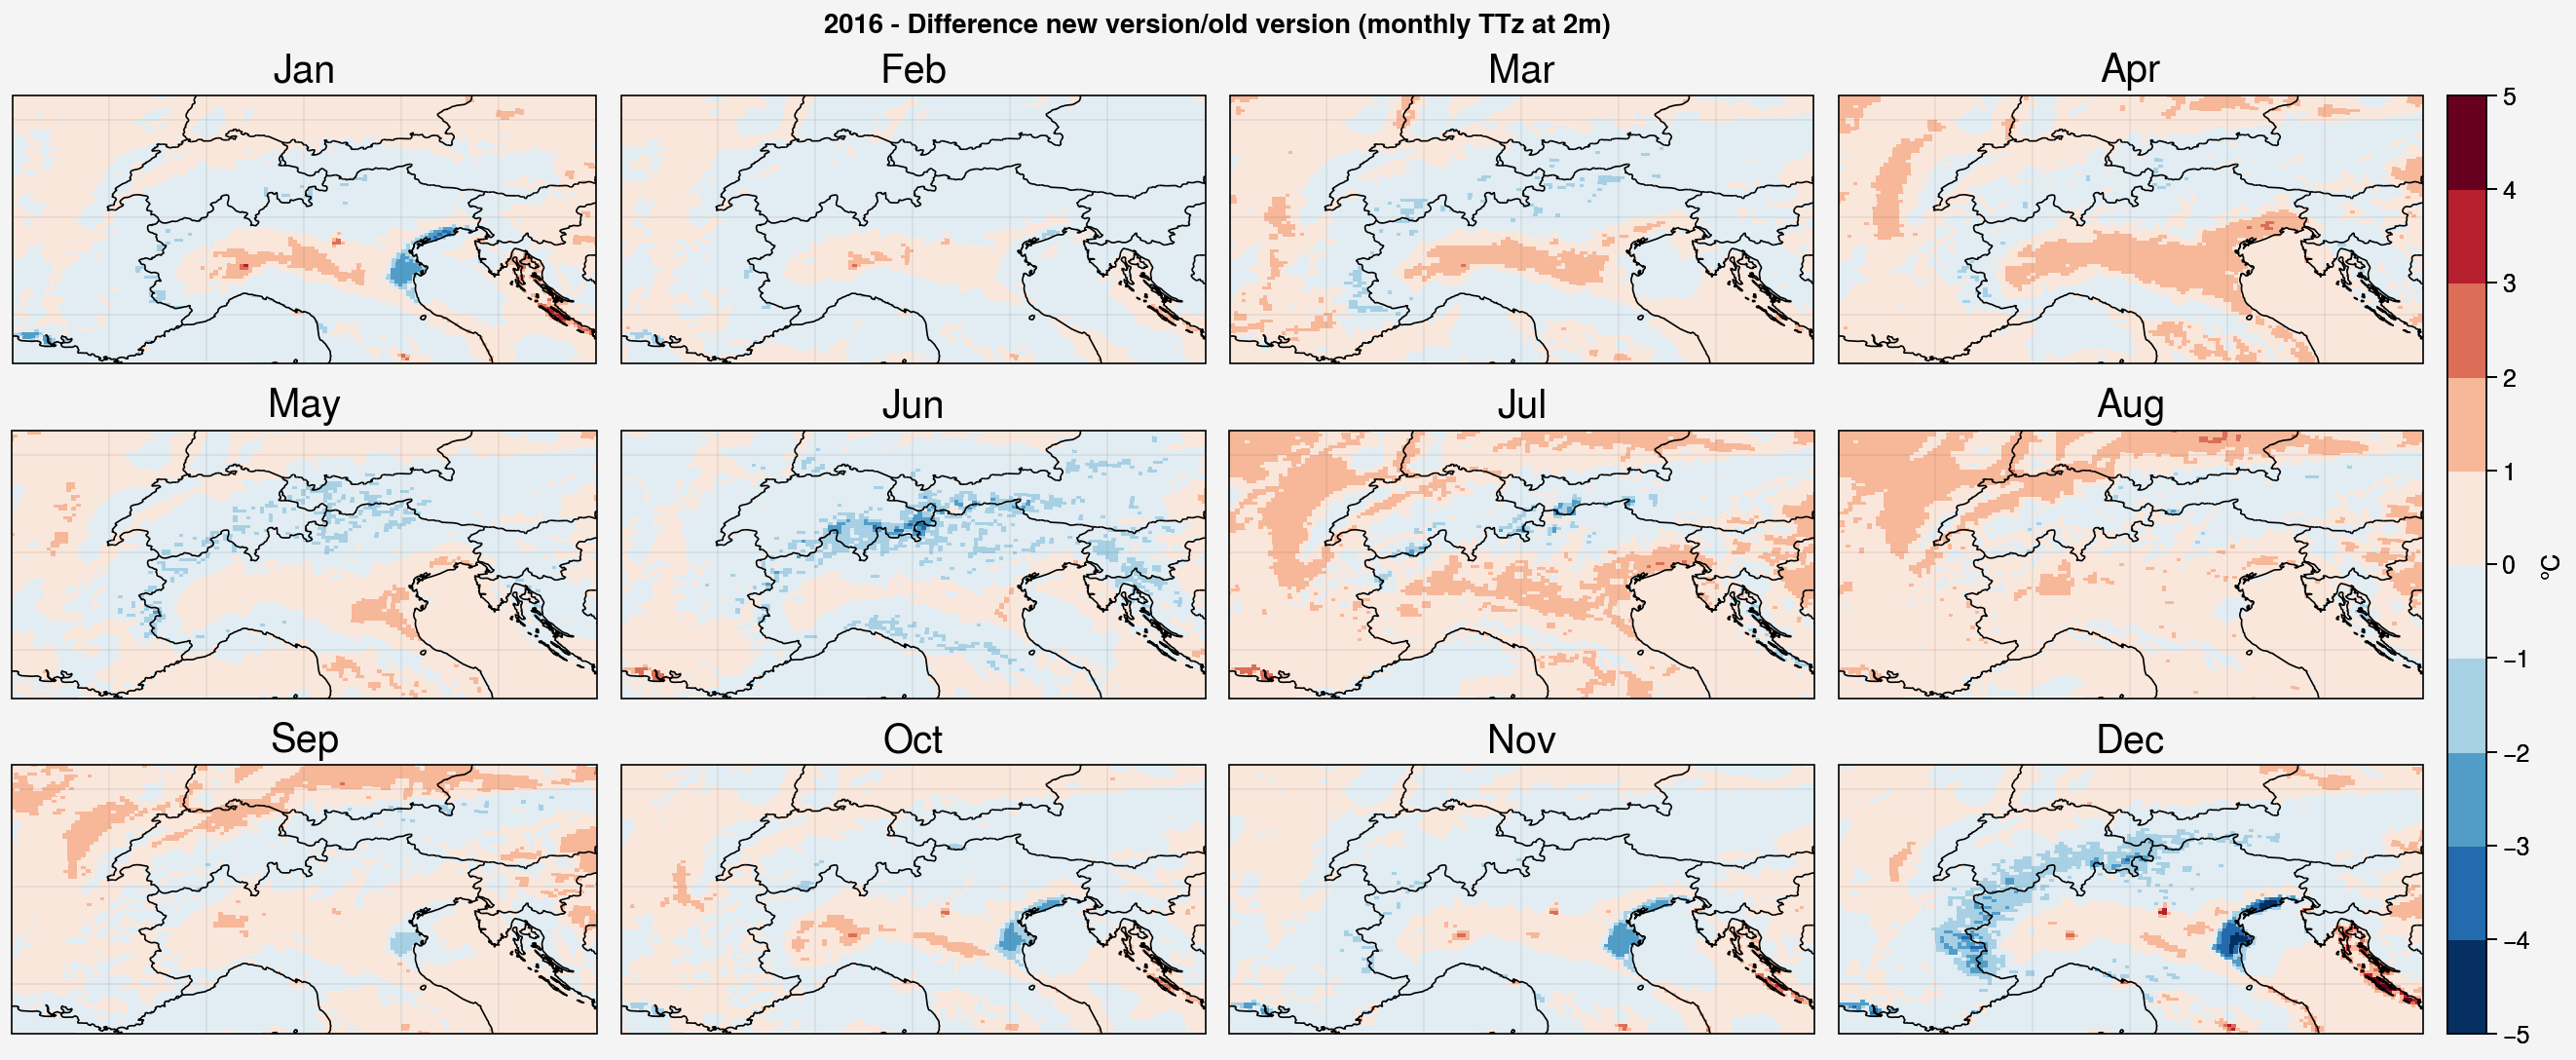

In [38]:
f, axs = pplt.subplots(proj='cyl',axwidth=3,ncols=4,nrows=3)

months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

for mon in range(12):
    m = axs[mon].pcolormesh(lon,lat,monthlyT_diff_2015[mon],levels=np.linspace(-5,5,11),cmap='RdBu_r')
    axs[mon].format(title=months[mon],titlesize='20px')

f.colorbar(m, label= '°C')

axs.format(**multiplot_format,suptitle="2015 - Difference new version/old version (monthly TTz at 2m)")


f, axs = pplt.subplots(proj='cyl',axwidth=3,ncols=4,nrows=3)

for mon in range(12):
    m = axs[mon].pcolormesh(lon,lat,monthlyT_diff_2016[mon],levels=np.linspace(-5,5,11),cmap='RdBu_r')
    axs[mon].format(title=months[mon],titlesize='20px')

f.colorbar(m, label= '°C')

axs.format(**multiplot_format,suptitle="2016 - Difference new version/old version (monthly TTz at 2m)")

/home/castelli/miniforge3/envs/phd_v1/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/castelli/miniforge3/envs/phd_v1/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/castelli/miniforge3/envs/phd_v1/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/castelli/miniforge3/envs/phd_v1/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to ins

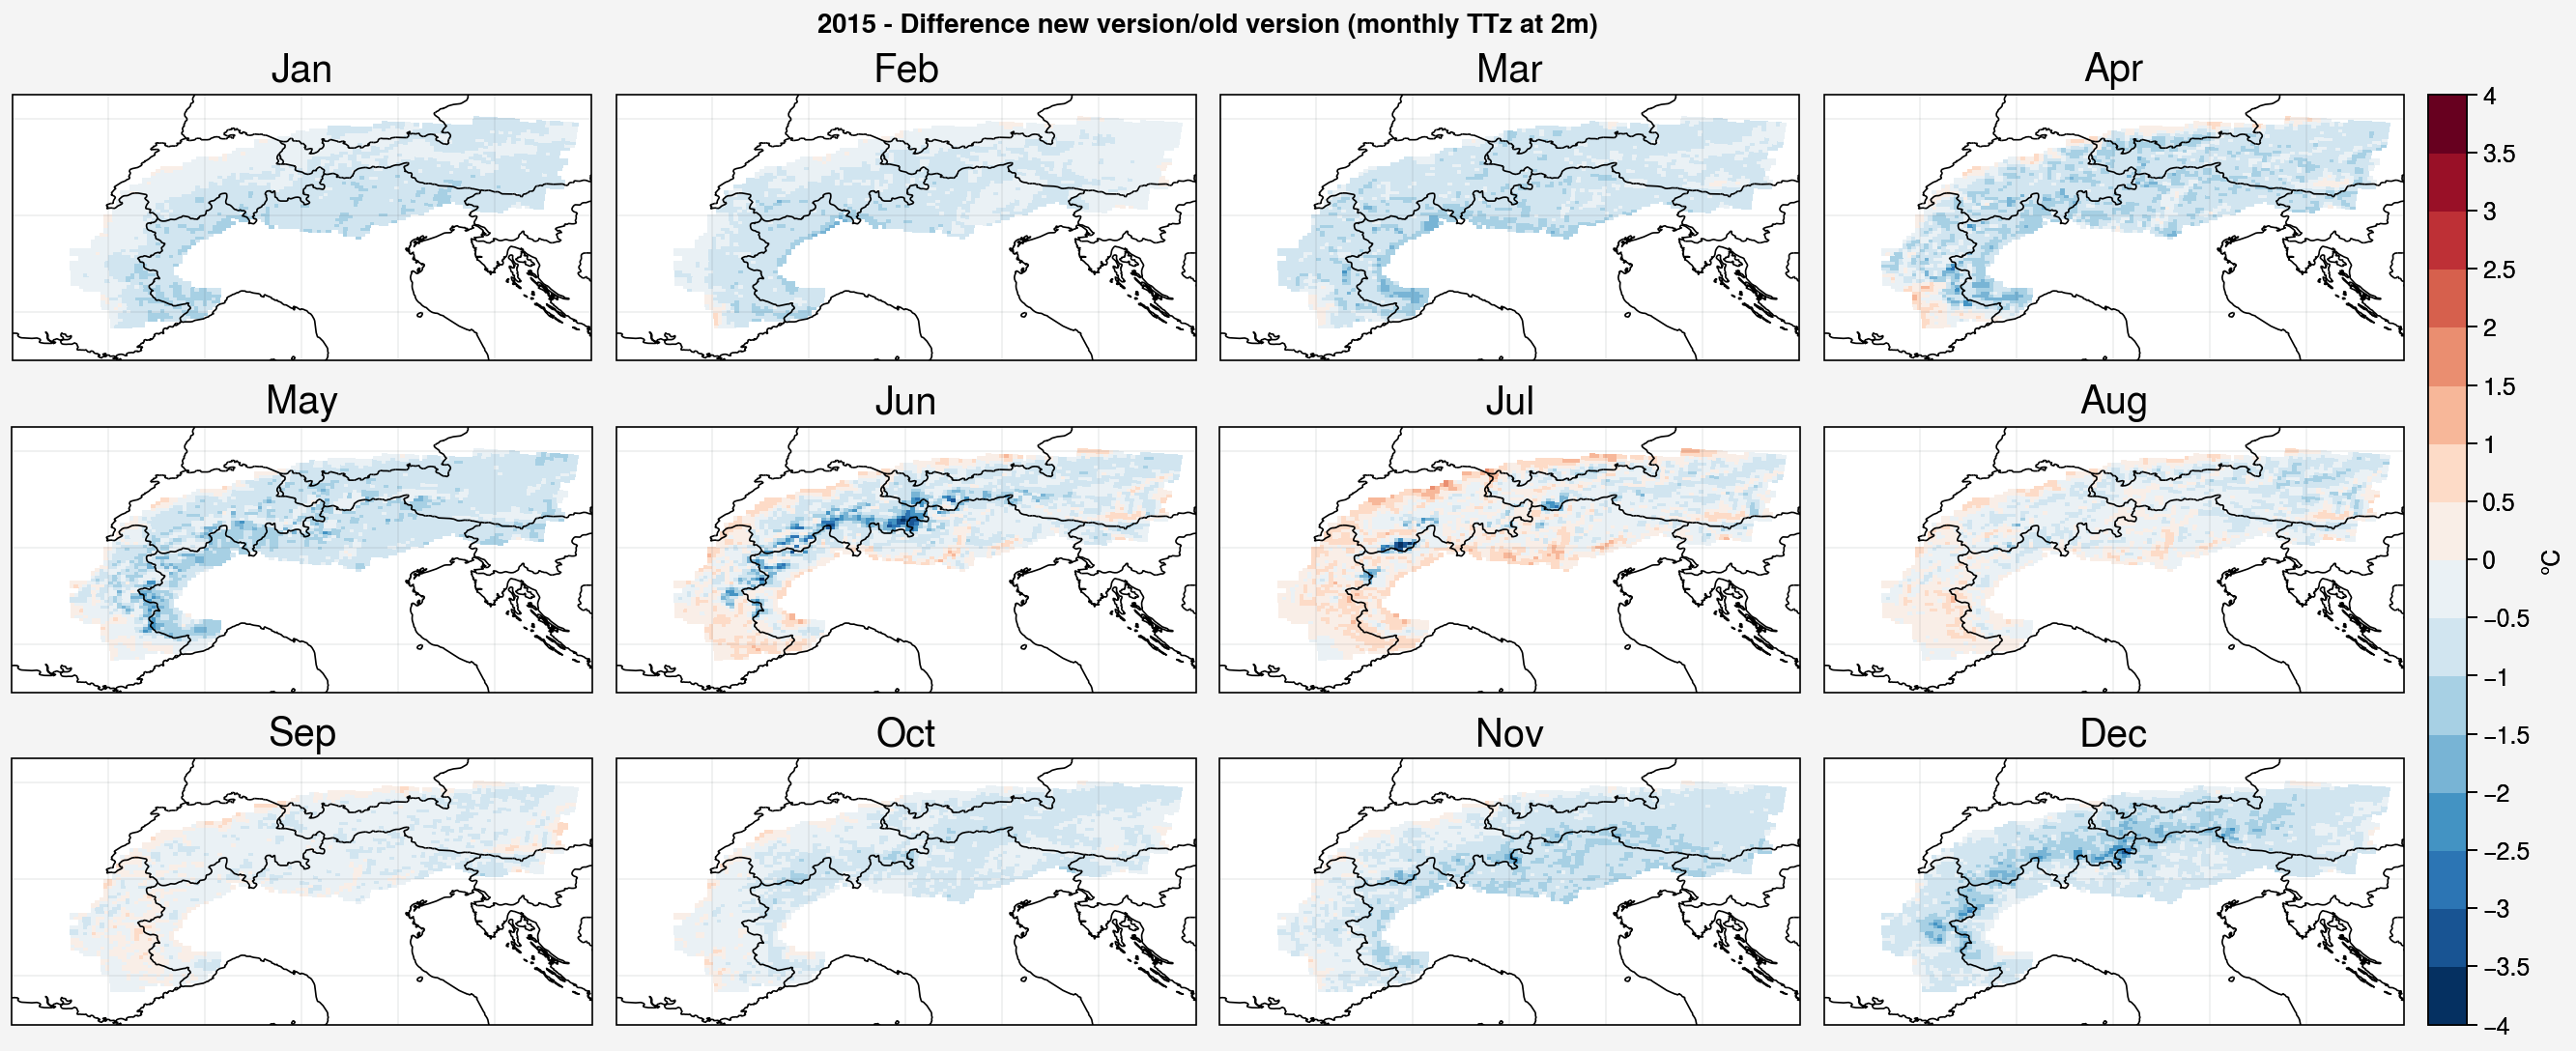

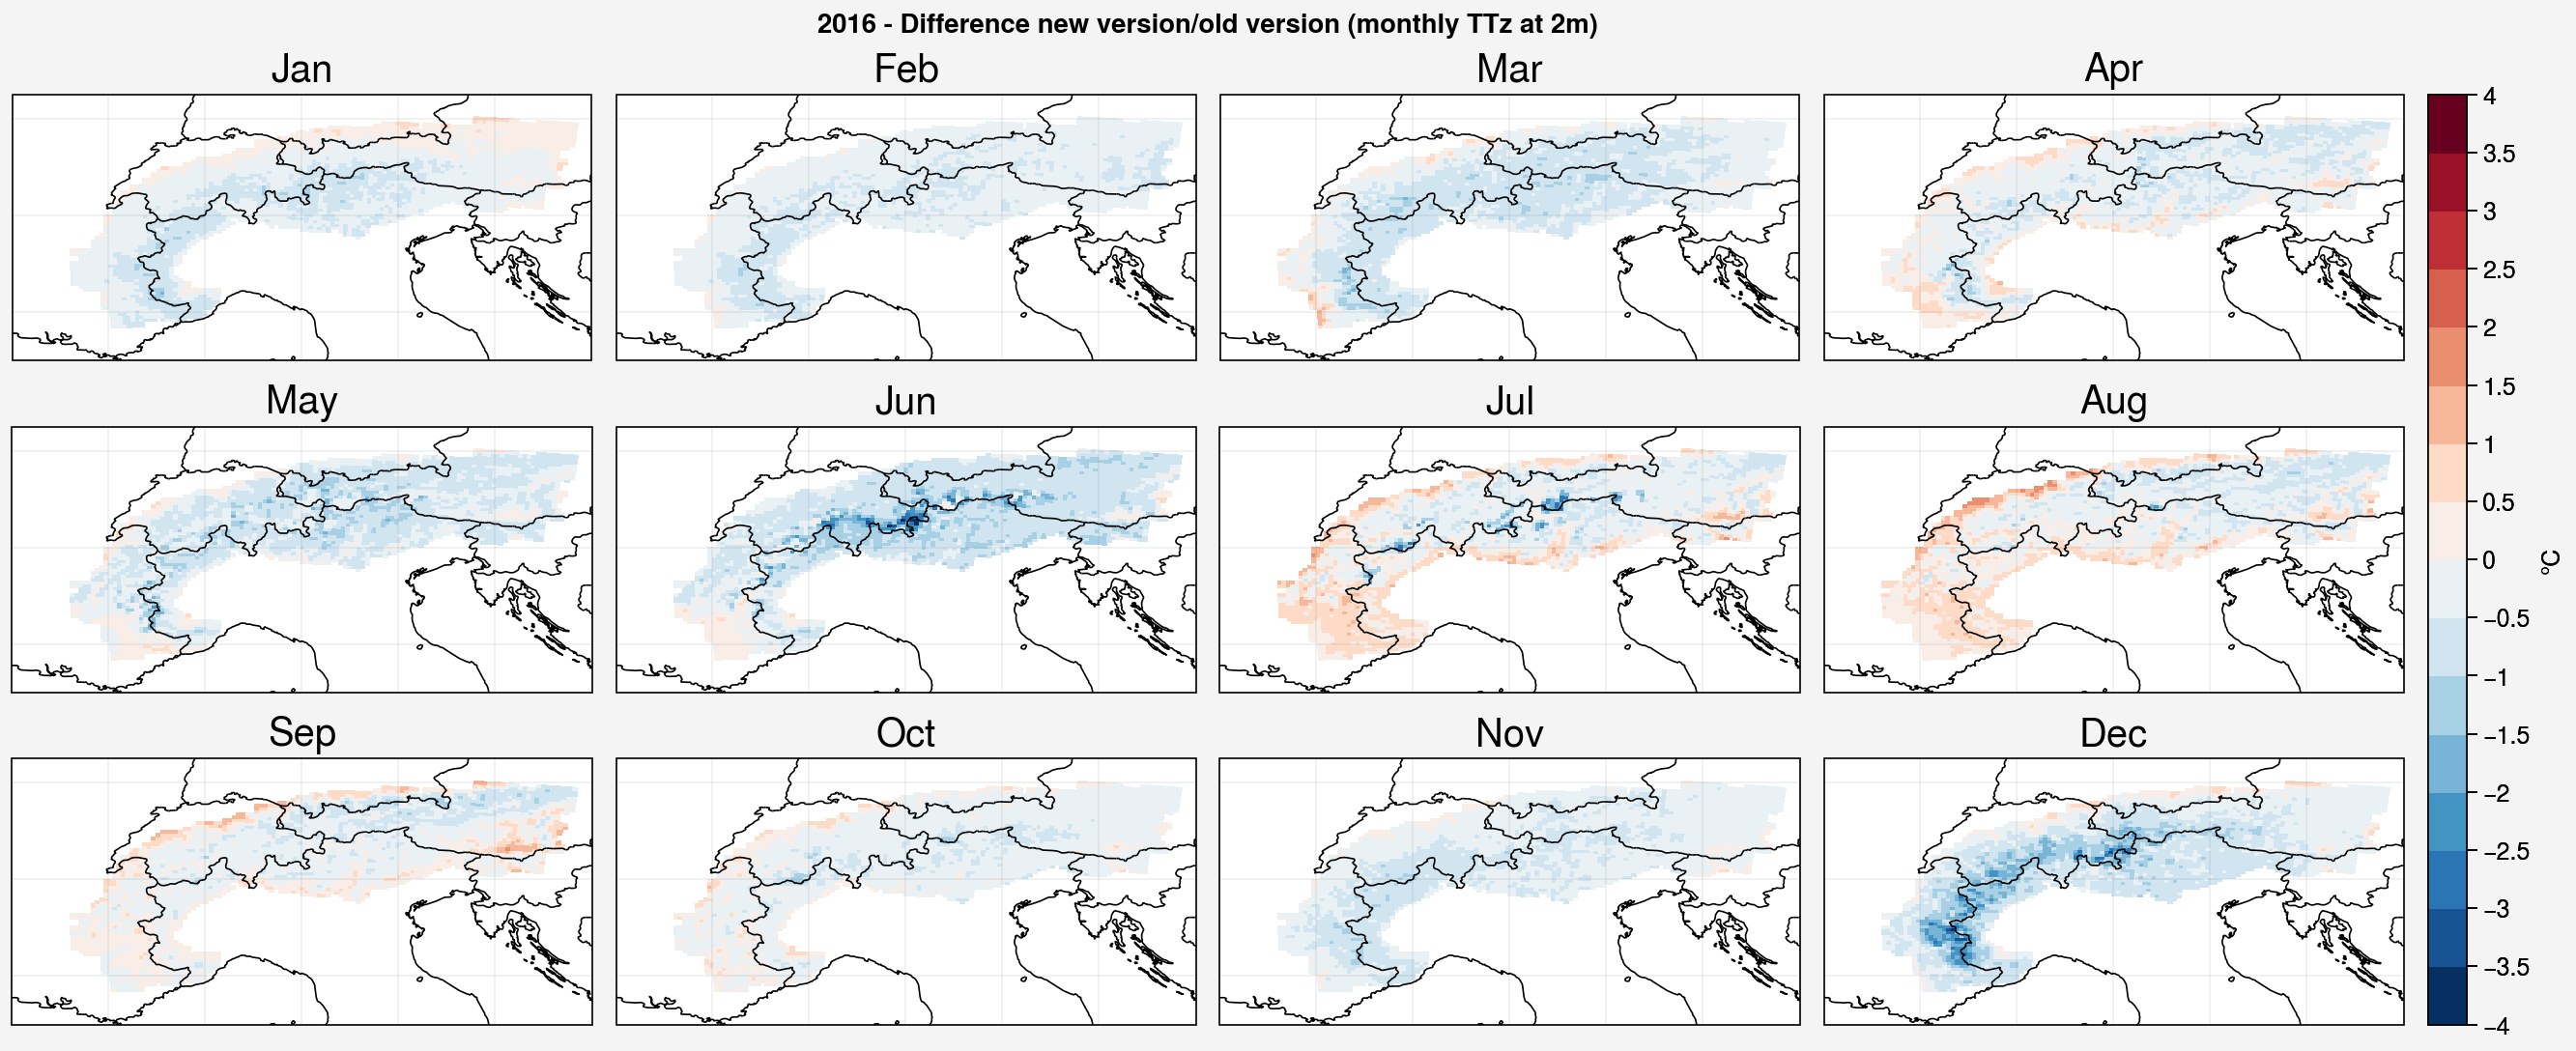

In [42]:
f, axs = pplt.subplots(proj='cyl',axwidth=3,ncols=4,nrows=3)

months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

for mon in range(12):
    monthlyT_diff_2015_alps = np.ma.masked_array(monthlyT_diff_2015[mon],mask=np.invert(alps))
    m = axs[mon].pcolormesh(lon,lat,monthlyT_diff_2015_alps,levels=np.linspace(-4,4,17),cmap='RdBu_r')
    axs[mon].format(title=months[mon],titlesize='20px')

f.colorbar(m, label= '°C')

axs.format(**multiplot_format,suptitle="2015 - Difference new version/old version (monthly TTz at 2m)")


f, axs = pplt.subplots(proj='cyl',axwidth=3,ncols=4,nrows=3)

for mon in range(12):
    monthlyT_diff_2016_alps = np.ma.masked_array(monthlyT_diff_2016[mon],mask=np.invert(alps))
    m = axs[mon].pcolormesh(lon,lat,monthlyT_diff_2016_alps,levels=np.linspace(-4,4,17),cmap='RdBu_r')
    axs[mon].format(title=months[mon],titlesize='20px')

f.colorbar(m, label= '°C')

axs.format(**multiplot_format,suptitle="2016 - Difference new version/old version (monthly TTz at 2m)")



/home/castelli/miniforge3/envs/phd_v1/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/castelli/miniforge3/envs/phd_v1/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/castelli/miniforge3/envs/phd_v1/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/castelli/miniforge3/envs/phd_v1/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to ins

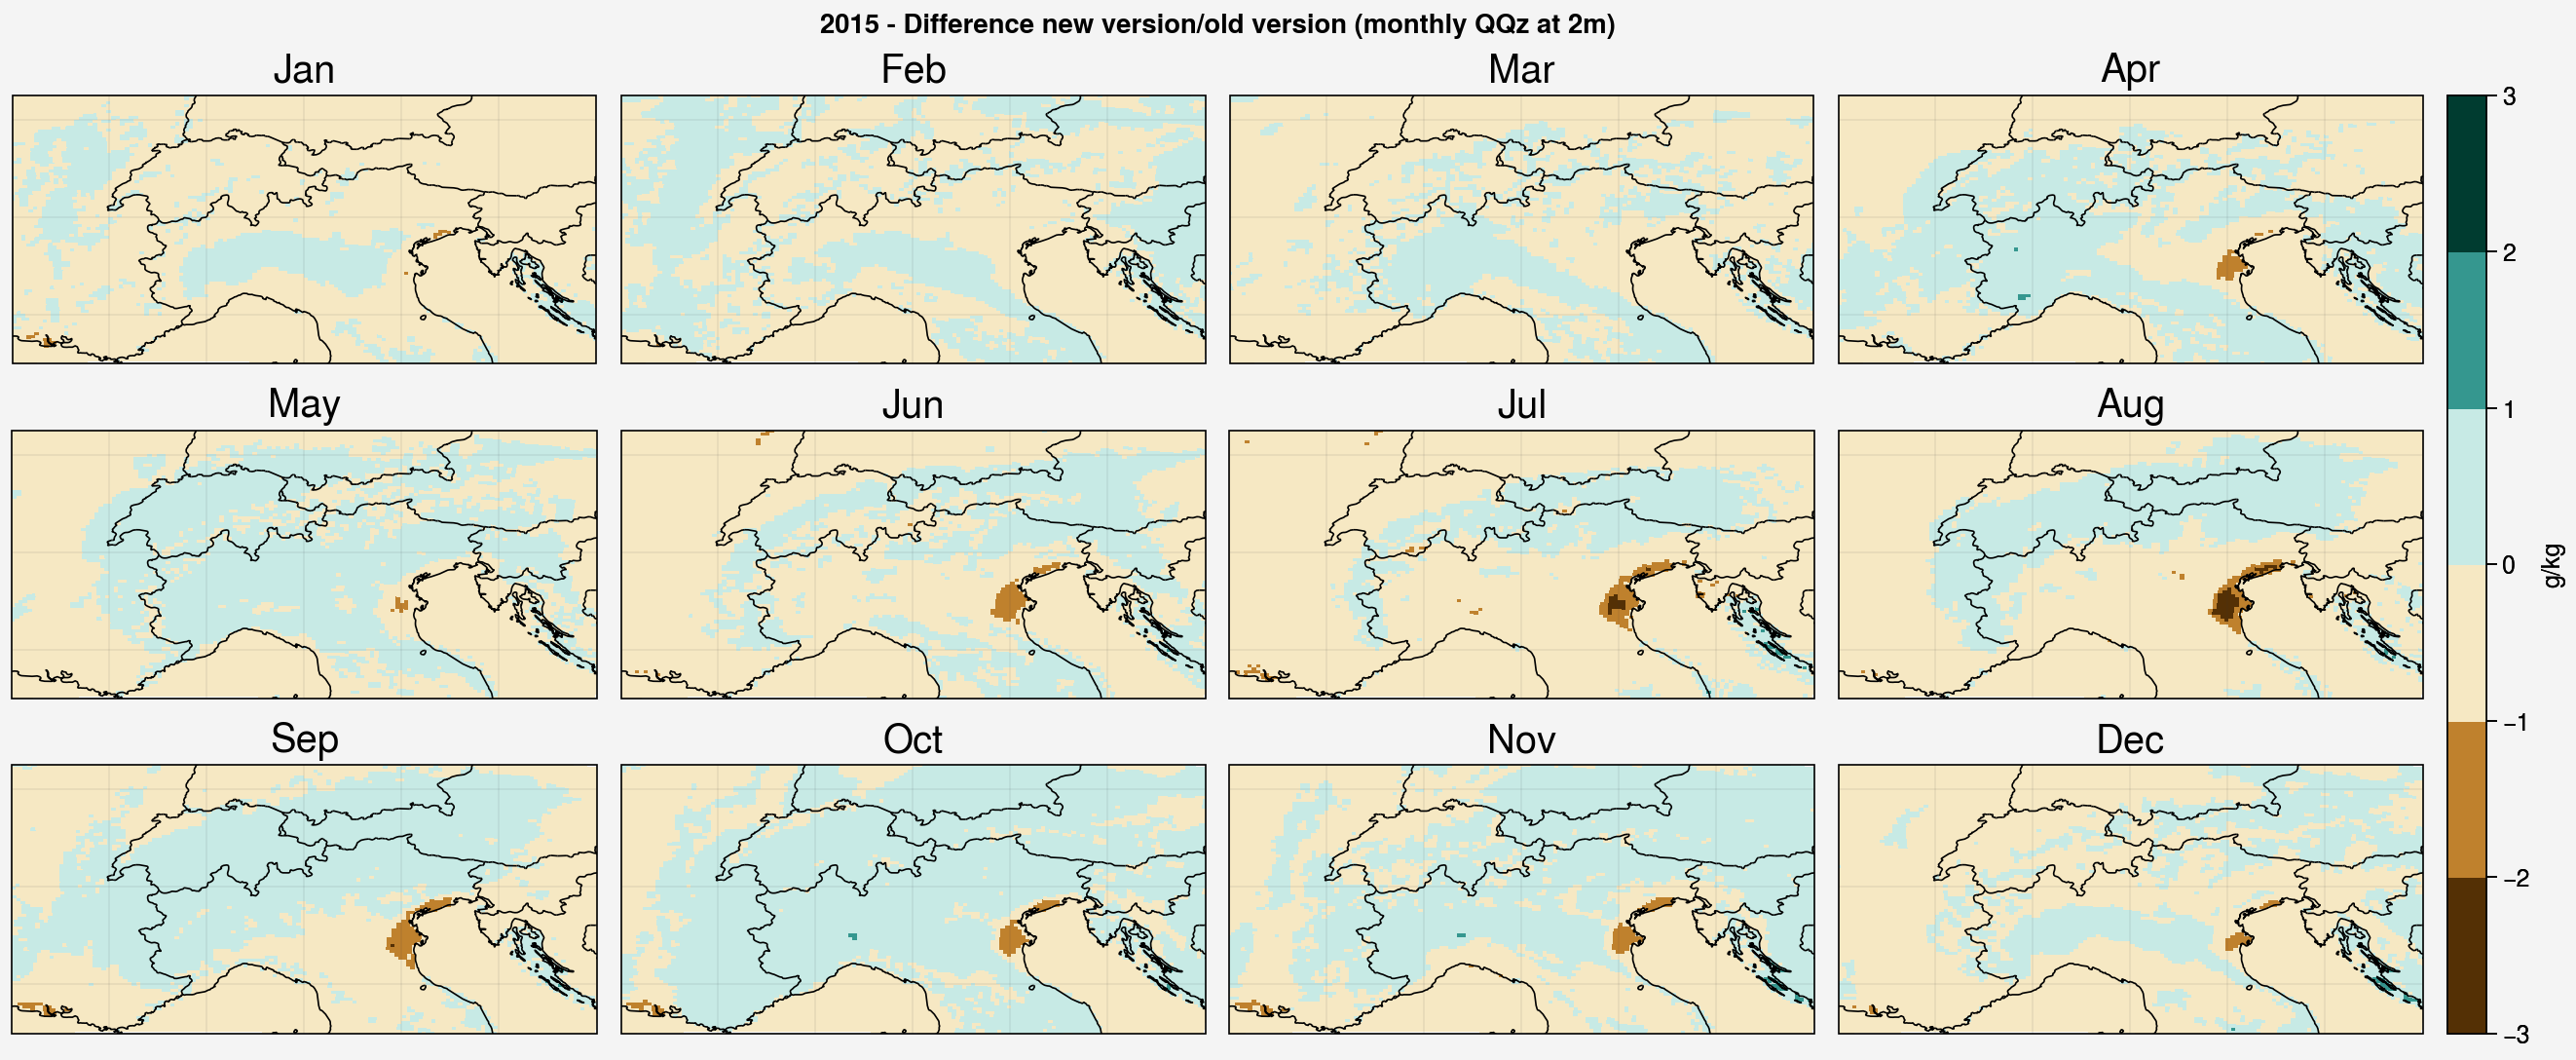

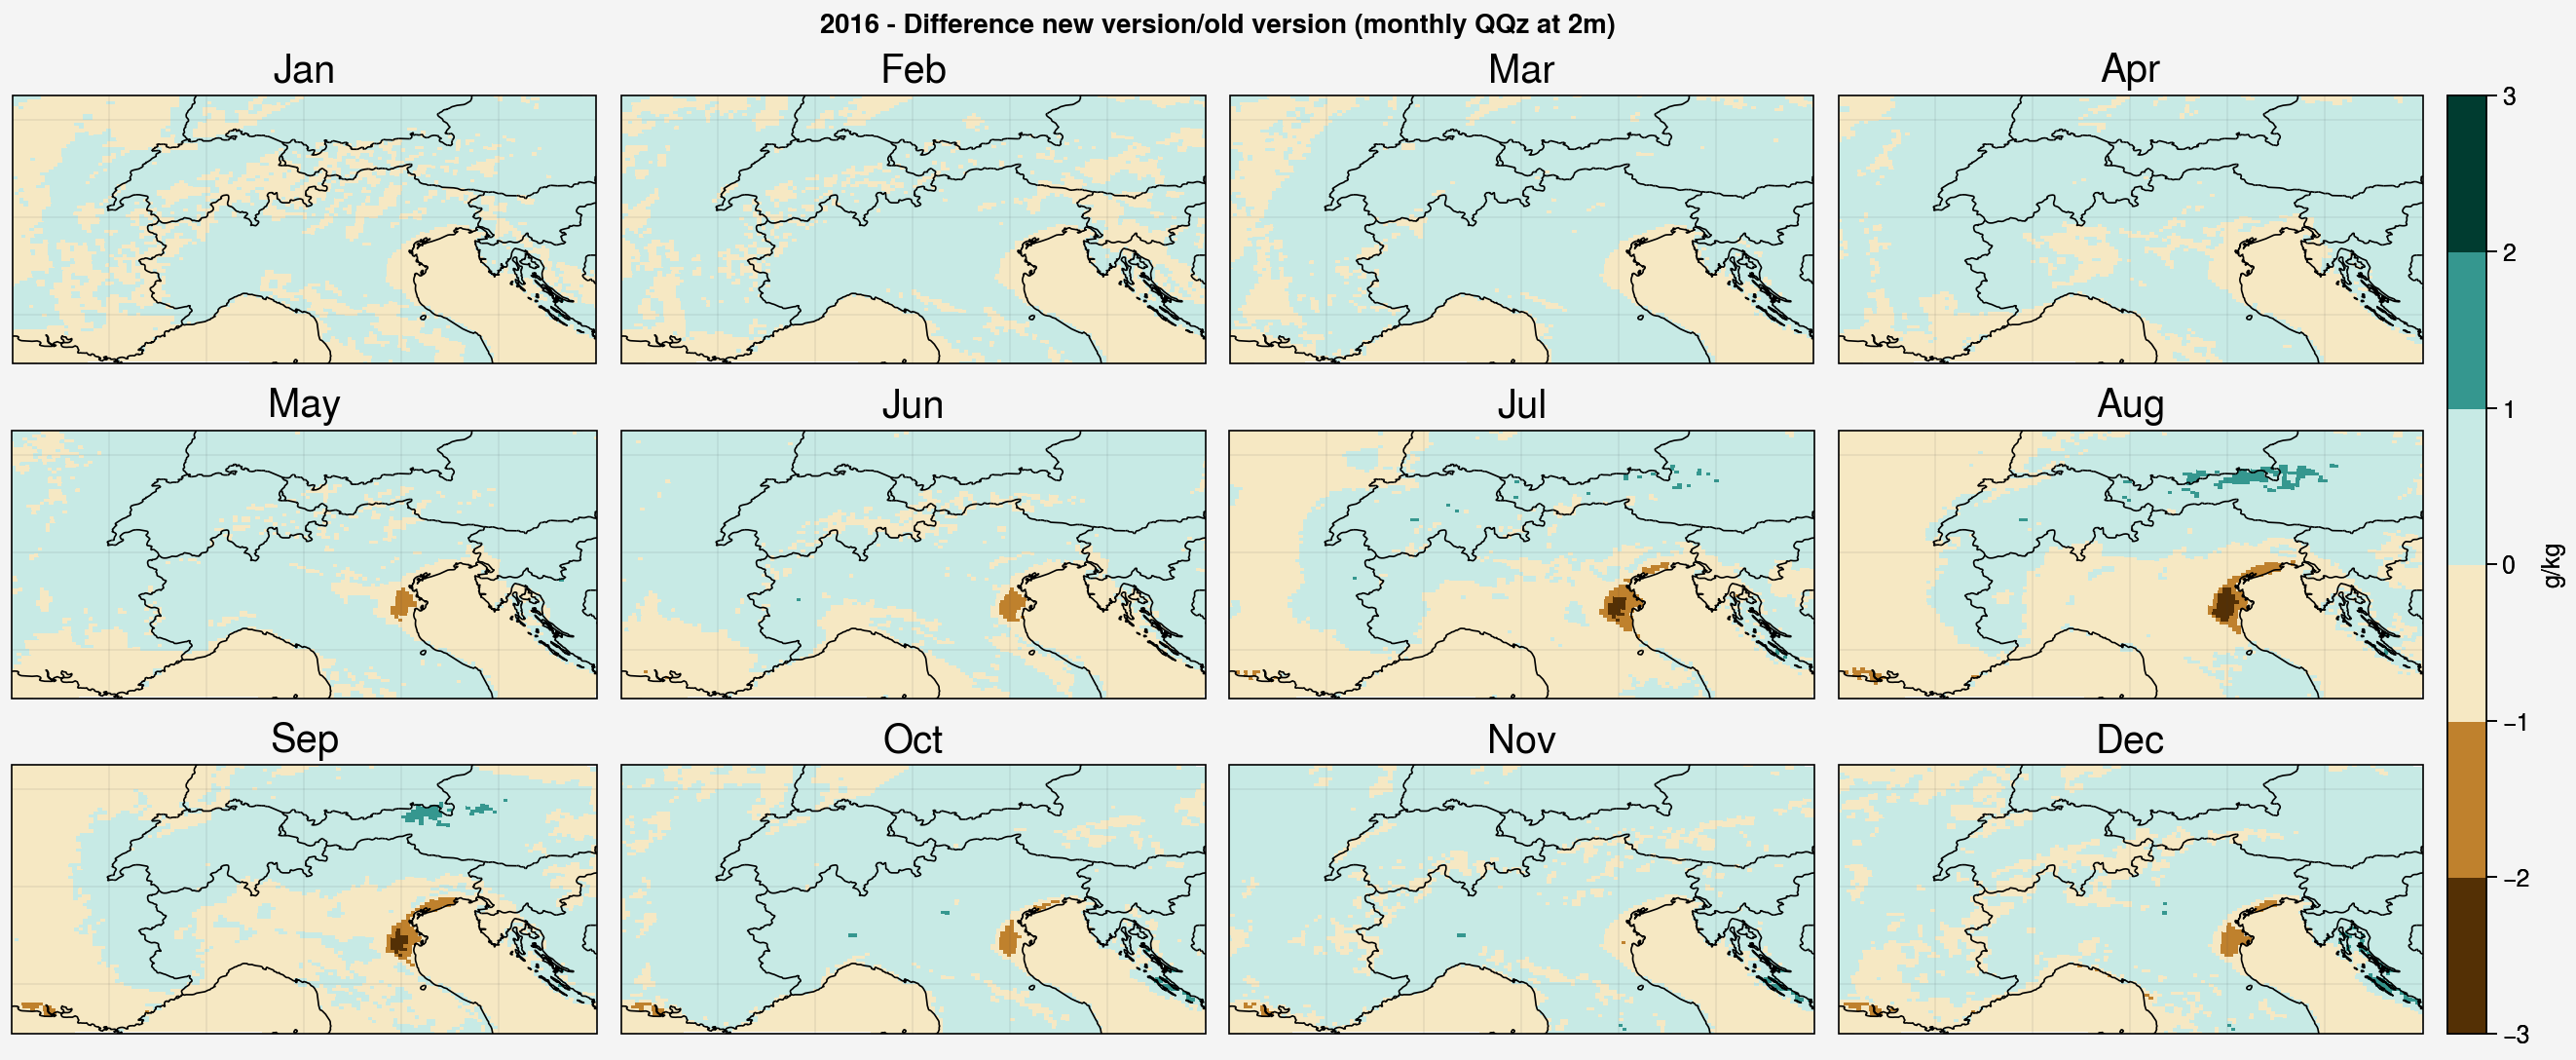

In [43]:
f, axs = pplt.subplots(proj='cyl',axwidth=3,ncols=4,nrows=3)

months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

for mon in range(12):
    m = axs[mon].pcolormesh(lon,lat,monthlyQQz_diff_2015[mon],levels=np.linspace(-3,3,7),cmap='BrBG')
    axs[mon].format(title=months[mon],titlesize='20px')

f.colorbar(m, label= 'g/kg')

axs.format(**multiplot_format,suptitle="2015 - Difference new version/old version (monthly QQz at 2m)")


f, axs = pplt.subplots(proj='cyl',axwidth=3,ncols=4,nrows=3)

for mon in range(12):
    m = axs[mon].pcolormesh(lon,lat,monthlyQQz_diff_2016[mon],levels=np.linspace(-3,3,7),cmap='BrBG')
    axs[mon].format(title=months[mon],titlesize='20px')

f.colorbar(m, label= 'g/kg')

axs.format(**multiplot_format,suptitle="2016 - Difference new version/old version (monthly QQz at 2m)")

/home/castelli/miniforge3/envs/phd_v1/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/castelli/miniforge3/envs/phd_v1/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/castelli/miniforge3/envs/phd_v1/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/castelli/miniforge3/envs/phd_v1/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to ins

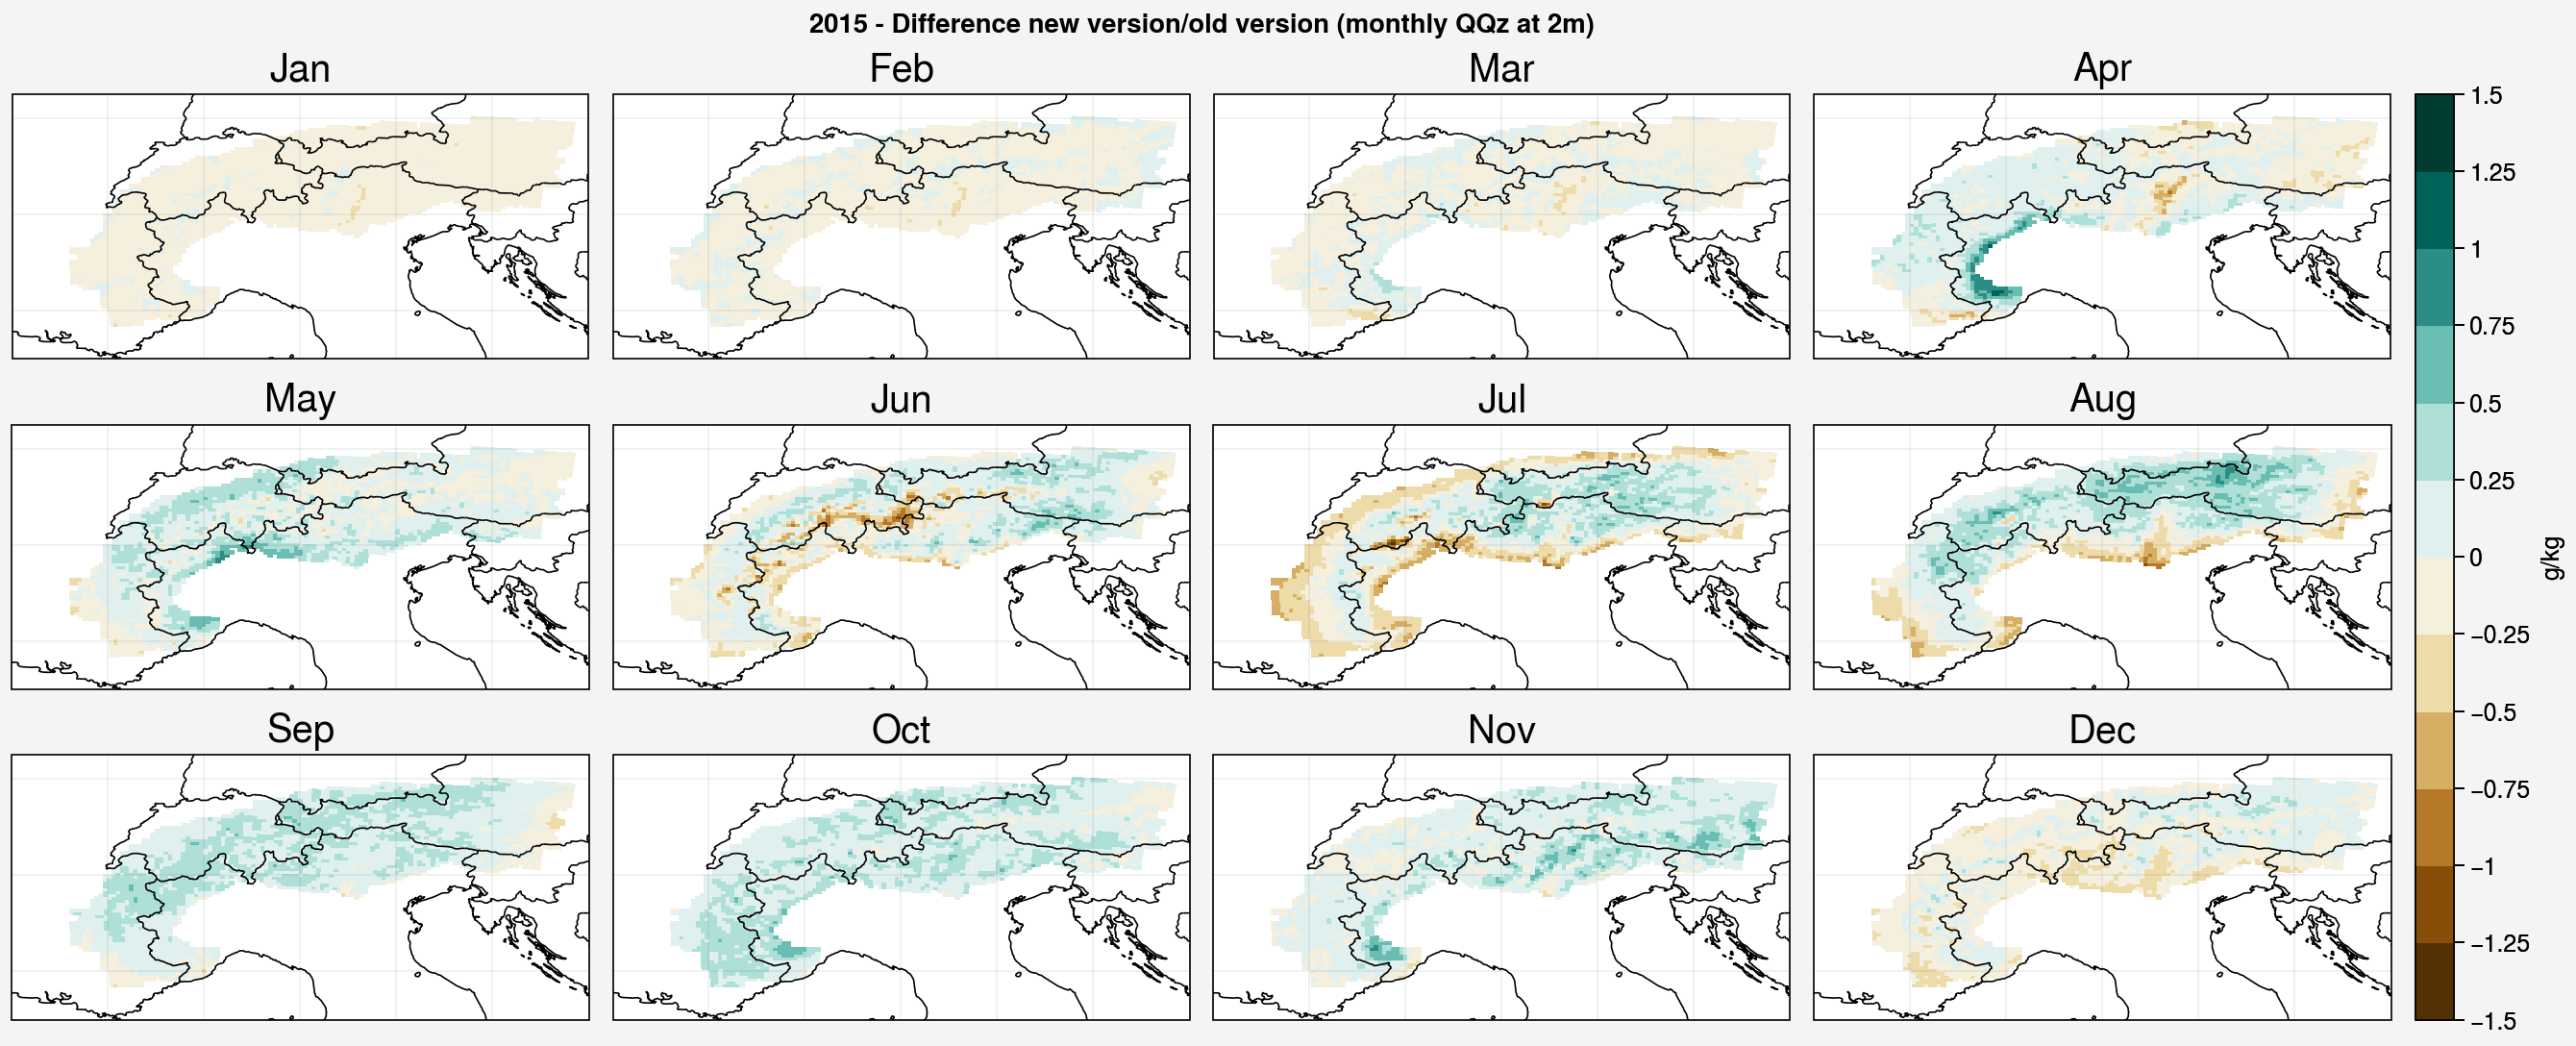

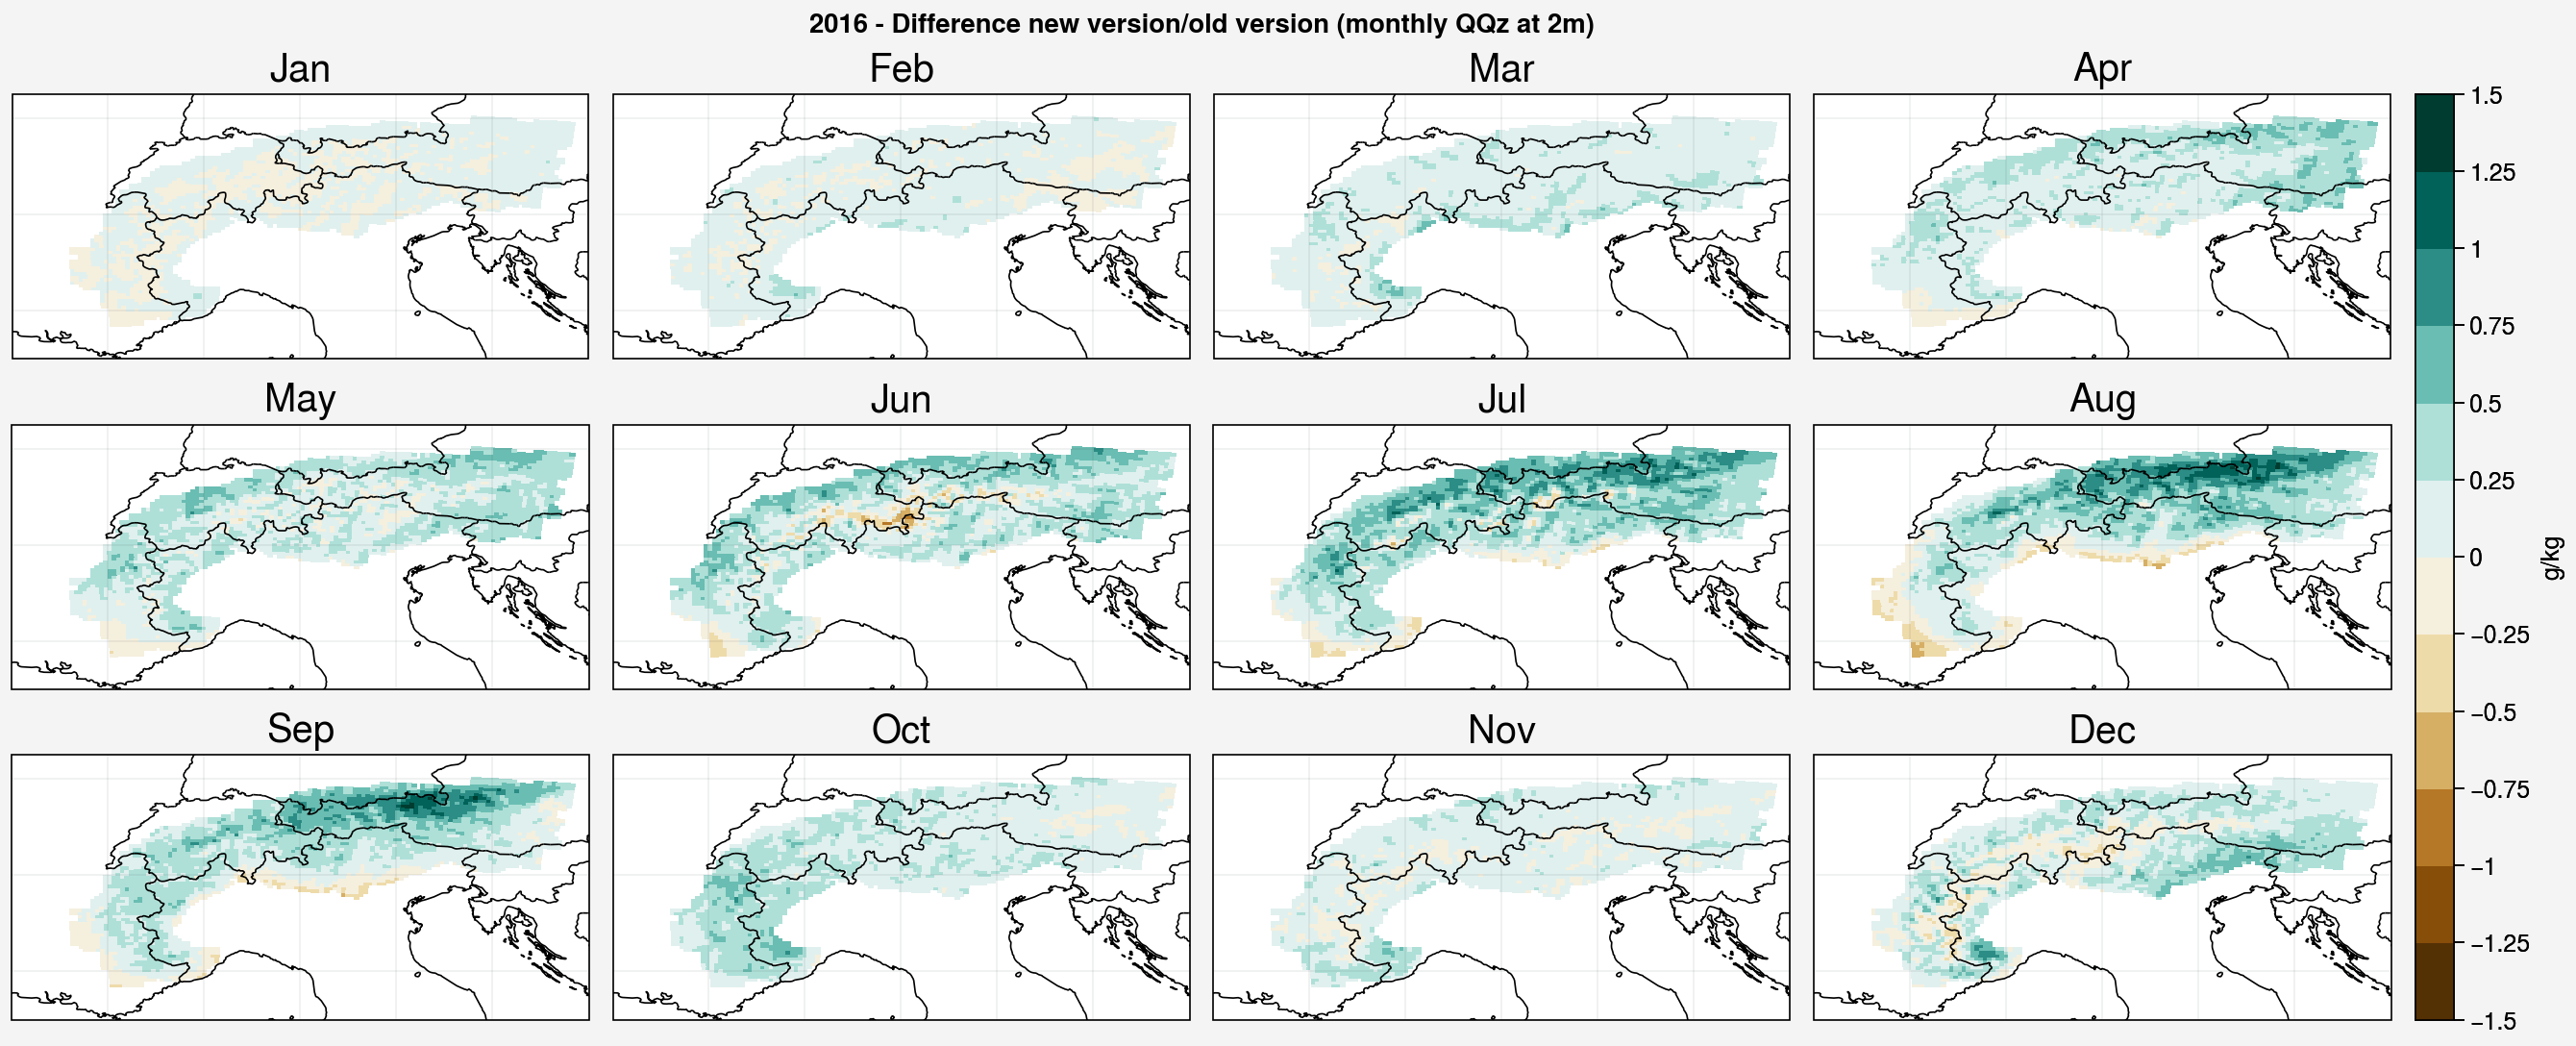

In [45]:
f, axs = pplt.subplots(proj='cyl',axwidth=3,ncols=4,nrows=3)

months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

for mon in range(12):
    monthlyQQz_diff_2015_alps = np.ma.masked_array(monthlyQQz_diff_2015[mon],mask=np.invert(alps))
    m = axs[mon].pcolormesh(lon,lat,monthlyQQz_diff_2015_alps,levels=np.linspace(-1.5,1.5,13),cmap='BrBG')
    axs[mon].format(title=months[mon],titlesize='20px')

f.colorbar(m, label= 'g/kg')

axs.format(**multiplot_format,suptitle="2015 - Difference new version/old version (monthly QQz at 2m)")


f, axs = pplt.subplots(proj='cyl',axwidth=3,ncols=4,nrows=3)

for mon in range(12):
    monthlyQQz_diff_2016_alps = np.ma.masked_array(monthlyQQz_diff_2016[mon],mask=np.invert(alps))
    m = axs[mon].pcolormesh(lon,lat,monthlyQQz_diff_2016_alps,levels=np.linspace(-1.5,1.5,13),cmap='BrBG')
    axs[mon].format(title=months[mon],titlesize='20px')

f.colorbar(m, label= 'g/kg')

axs.format(**multiplot_format,suptitle="2016 - Difference new version/old version (monthly QQz at 2m)")

/home/castelli/miniforge3/envs/phd_v1/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/castelli/miniforge3/envs/phd_v1/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/castelli/miniforge3/envs/phd_v1/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/castelli/miniforge3/envs/phd_v1/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to ins

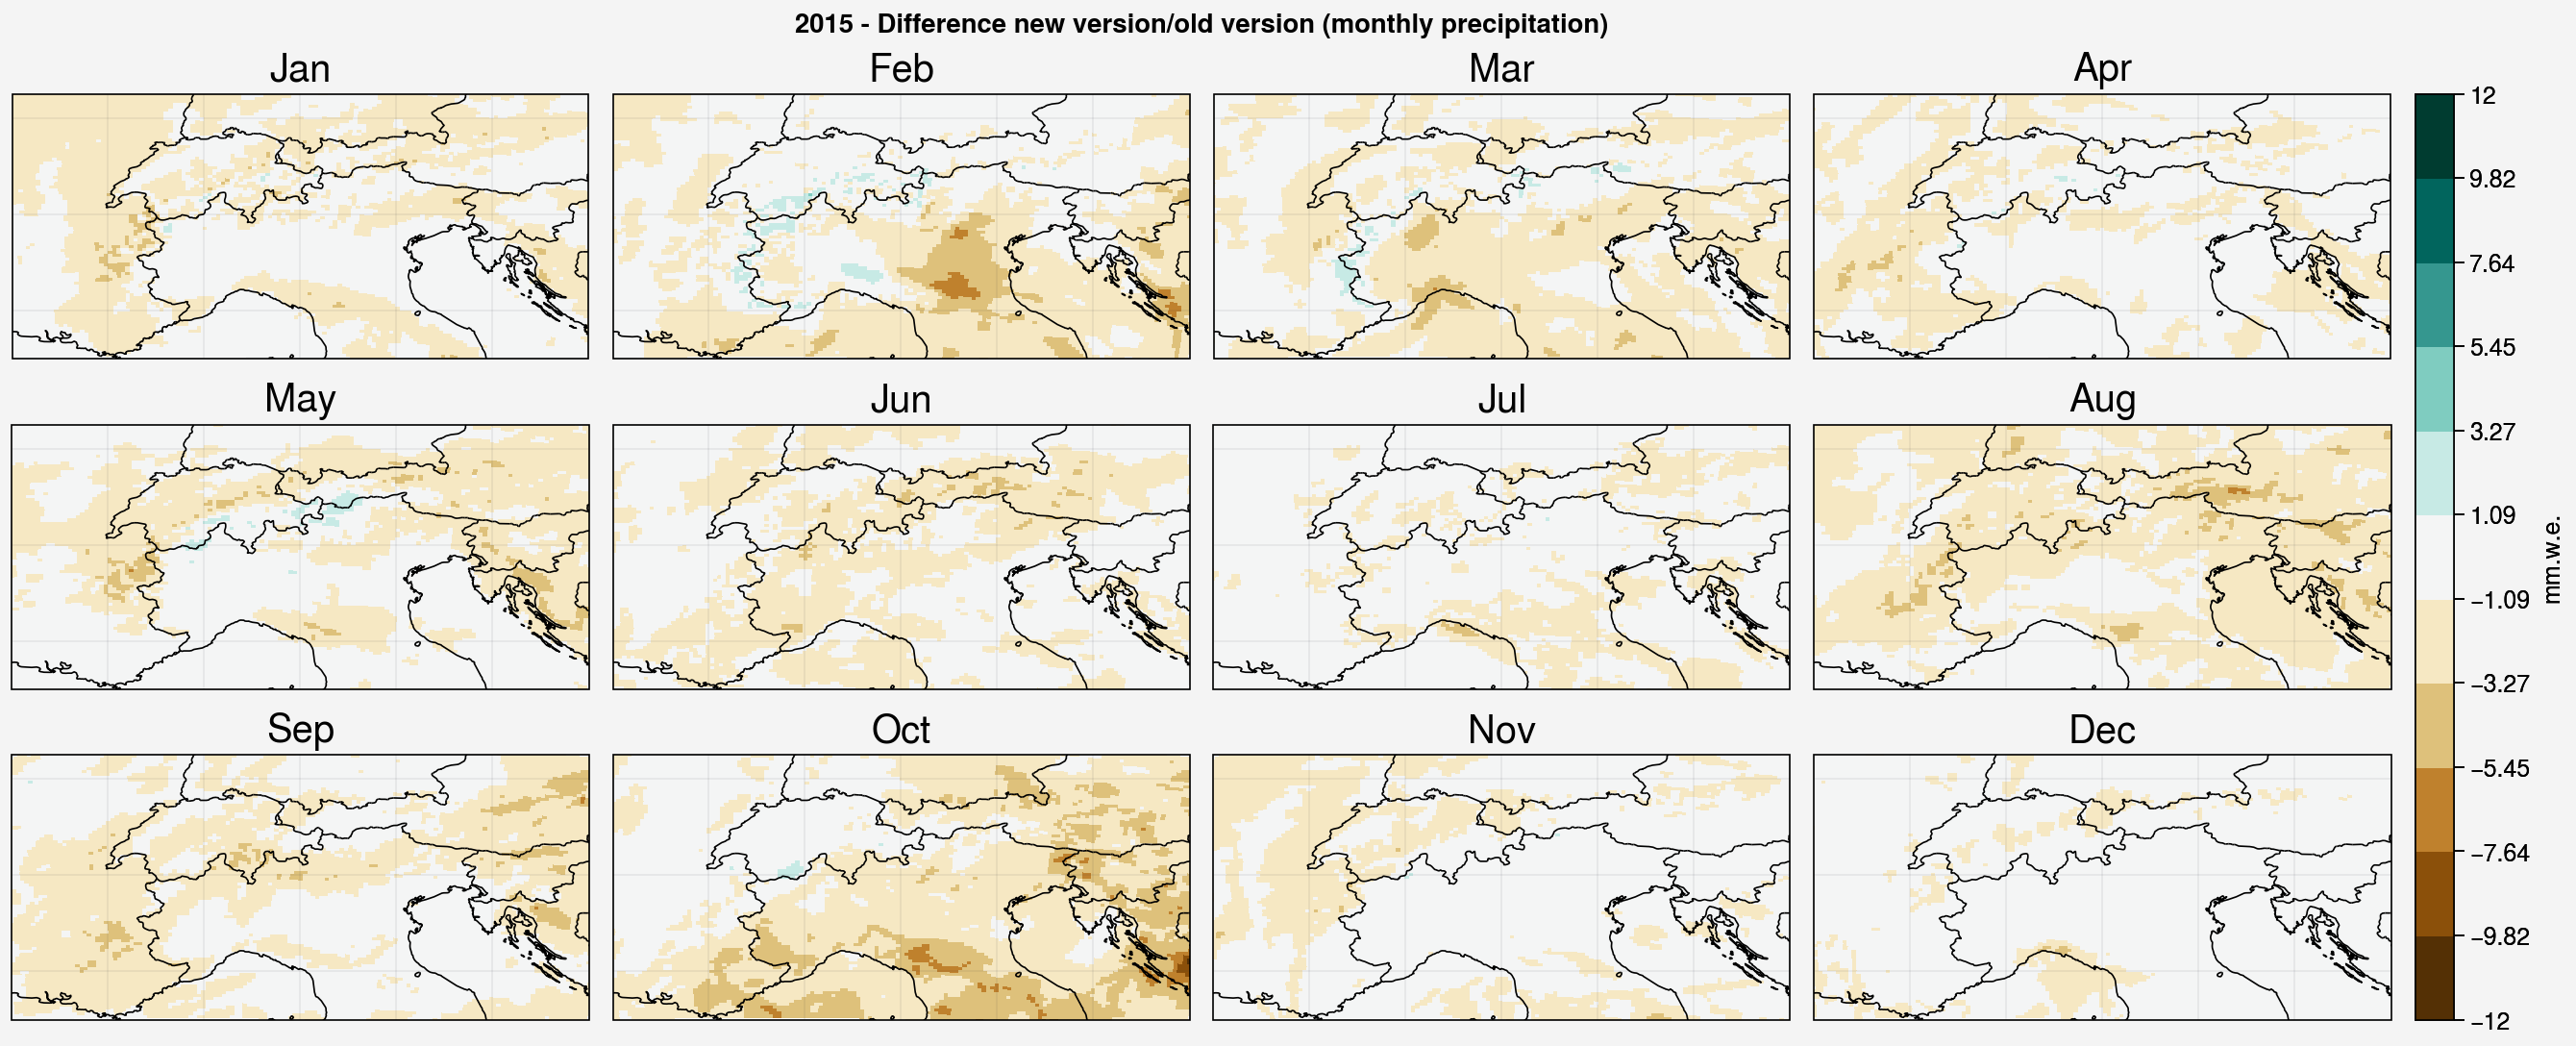

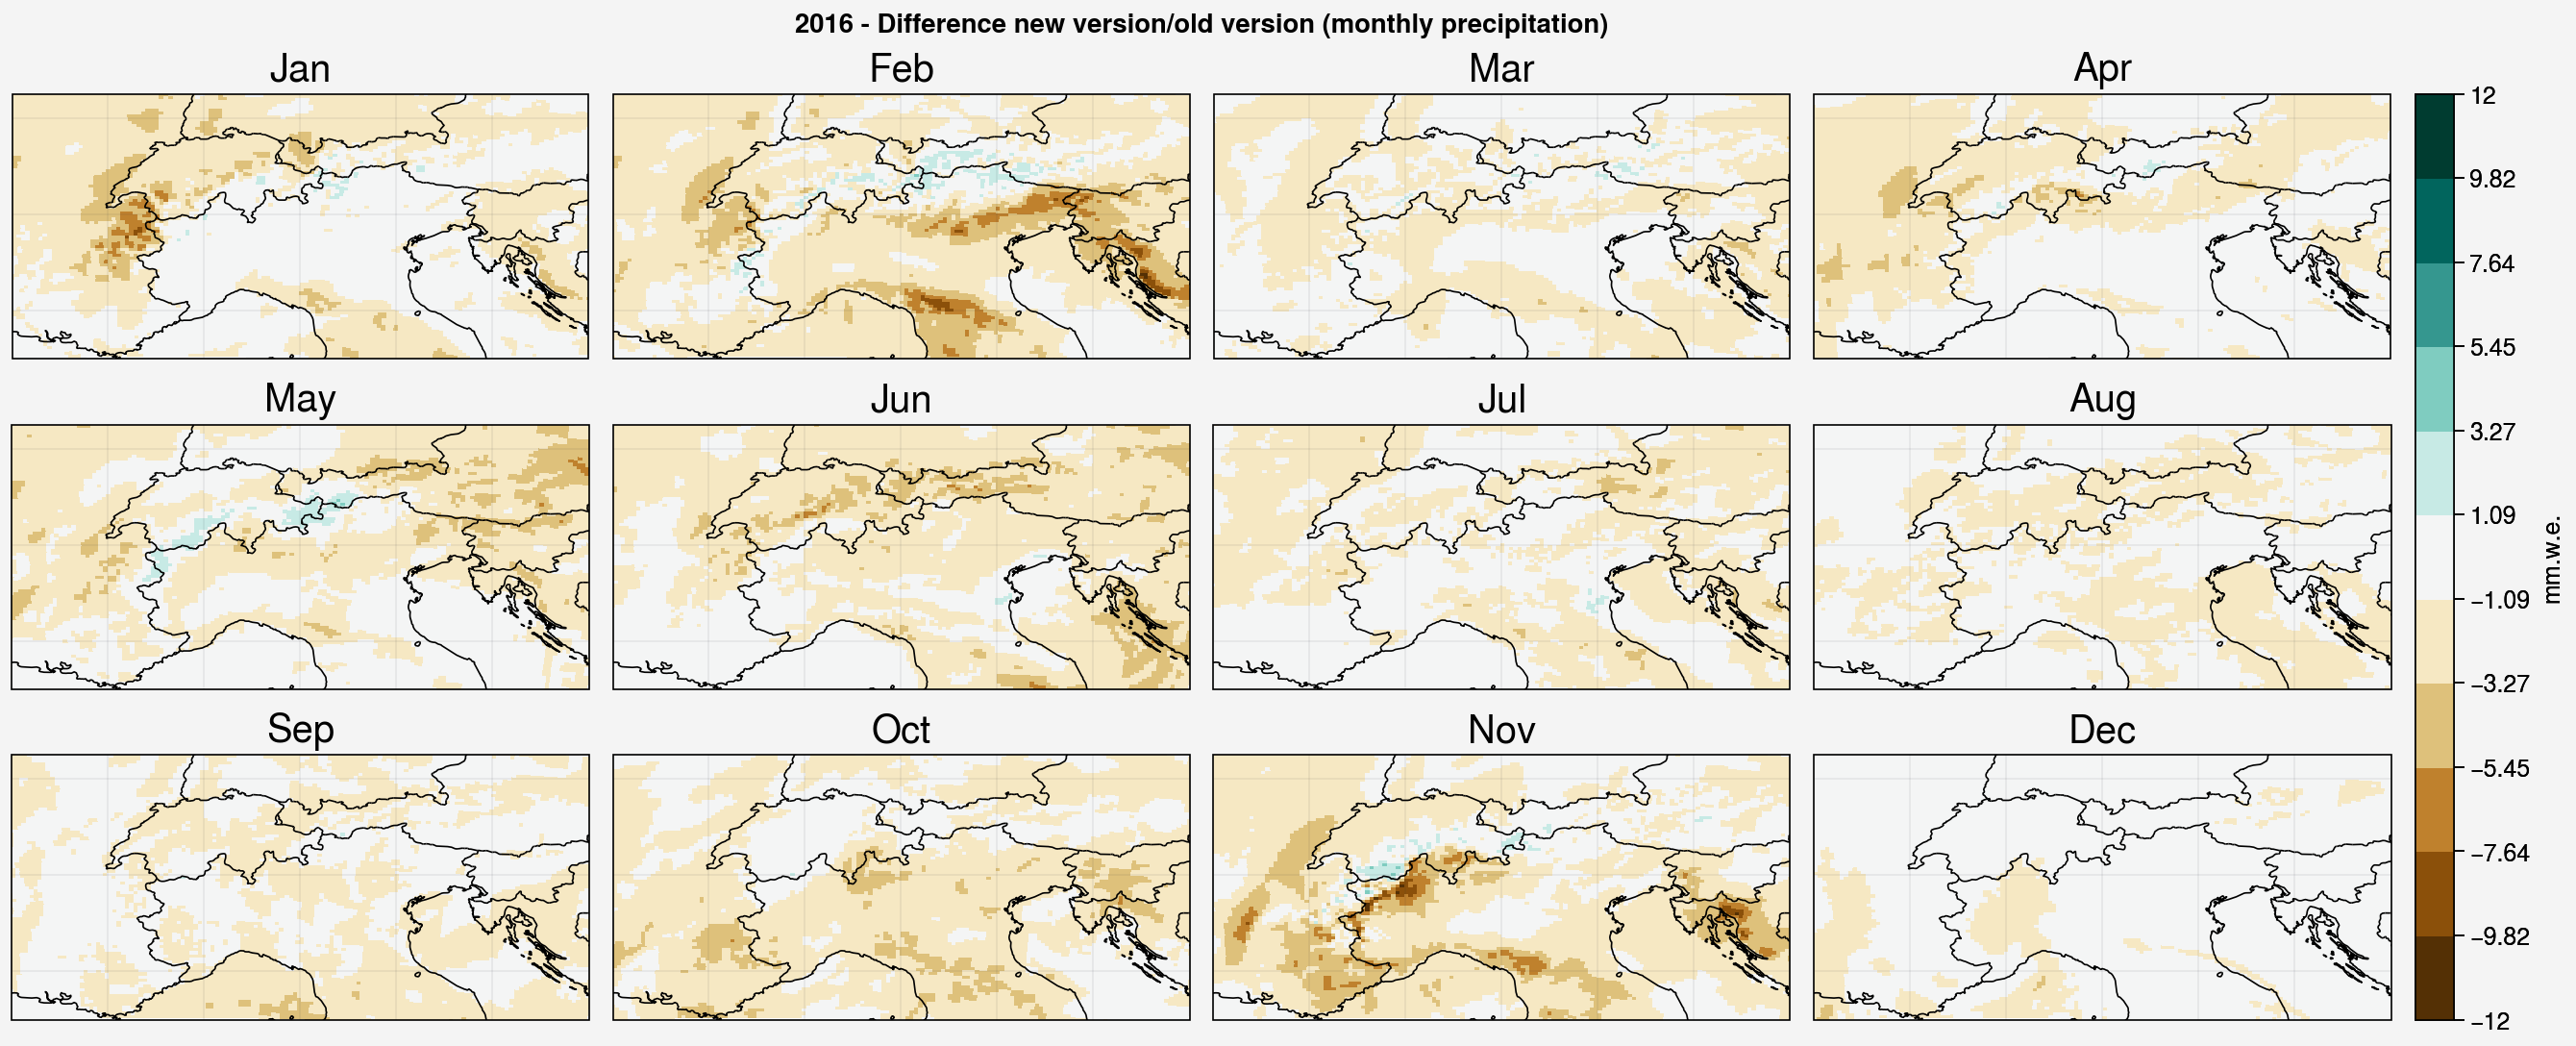

In [36]:
f, axs = pplt.subplots(proj='cyl',axwidth=3,ncols=4,nrows=3)

months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

for mon in range(12):
    m = axs[mon].pcolormesh(lon,lat,monthlyTP_diff_2015[mon],levels=np.linspace(-12,12,12),cmap='BrBG')
    axs[mon].format(title=months[mon],titlesize='20px')

f.colorbar(m, label= 'mm.w.e.')

axs.format(**multiplot_format,suptitle="2015 - Difference new version/old version (monthly precipitation)")


f, axs = pplt.subplots(proj='cyl',axwidth=3,ncols=4,nrows=3)

for mon in range(12):
    m = axs[mon].pcolormesh(lon,lat,monthlyTP_diff_2016[mon],levels=np.linspace(-12,12,12),cmap='BrBG')
    axs[mon].format(title=months[mon],titlesize='20px')

f.colorbar(m, label= 'mm.w.e.')

axs.format(**multiplot_format,suptitle="2016 - Difference new version/old version (monthly precipitation)")

#### Humidity QQz

/home/castelli/miniforge3/envs/phd_v1/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/castelli/miniforge3/envs/phd_v1/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/castelli/miniforge3/envs/phd_v1/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/castelli/miniforge3/envs/phd_v1/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to ins

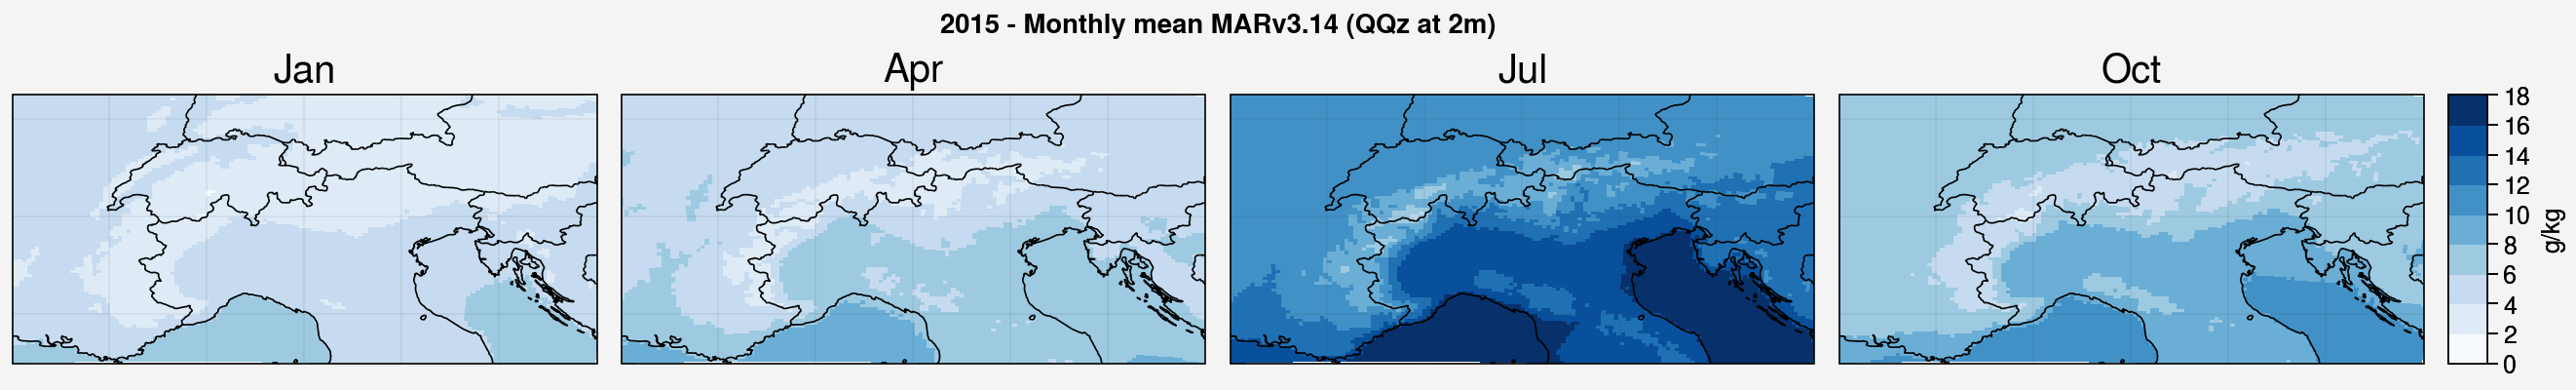

In [28]:
f, axs = pplt.subplots(proj='cyl',axwidth=3,ncols=4)

m = axs[0].pcolormesh(lon,lat,ds_QQz_test_v314_2015.QQz.isel(ztqlev=0)[:,jmin:jmax,imin:imax].groupby("time.month").mean("time")[0],
                      levels=np.linspace(0,18,10),cmap='Blues')
axs[0].format(title='Jan',titlesize='20px')

m = axs[1].pcolormesh(lon,lat,ds_QQz_test_v314_2015.QQz.isel(ztqlev=0)[:,jmin:jmax,imin:imax].groupby("time.month").mean("time")[3],
                      levels=np.linspace(0,18,10),cmap='Blues')
axs[1].format(title='Apr',titlesize='20px')

m = axs[2].pcolormesh(lon,lat,ds_QQz_test_v314_2015.QQz.isel(ztqlev=0)[:,jmin:jmax,imin:imax].groupby("time.month").mean("time")[6],
                      levels=np.linspace(0,18,10),cmap='Blues')
axs[2].format(title='Jul',titlesize='20px')

m = axs[3].pcolormesh(lon,lat,ds_QQz_test_v314_2015.QQz.isel(ztqlev=0)[:,jmin:jmax,imin:imax].groupby("time.month").mean("time")[9],
                      levels=np.linspace(0,18,10),cmap='Blues')
axs[3].format(title='Oct',titlesize='20px')
f.colorbar(m, label= 'g/kg')

axs.format(**multiplot_format,suptitle="2015 - Monthly mean MARv3.14 (QQz at 2m)")

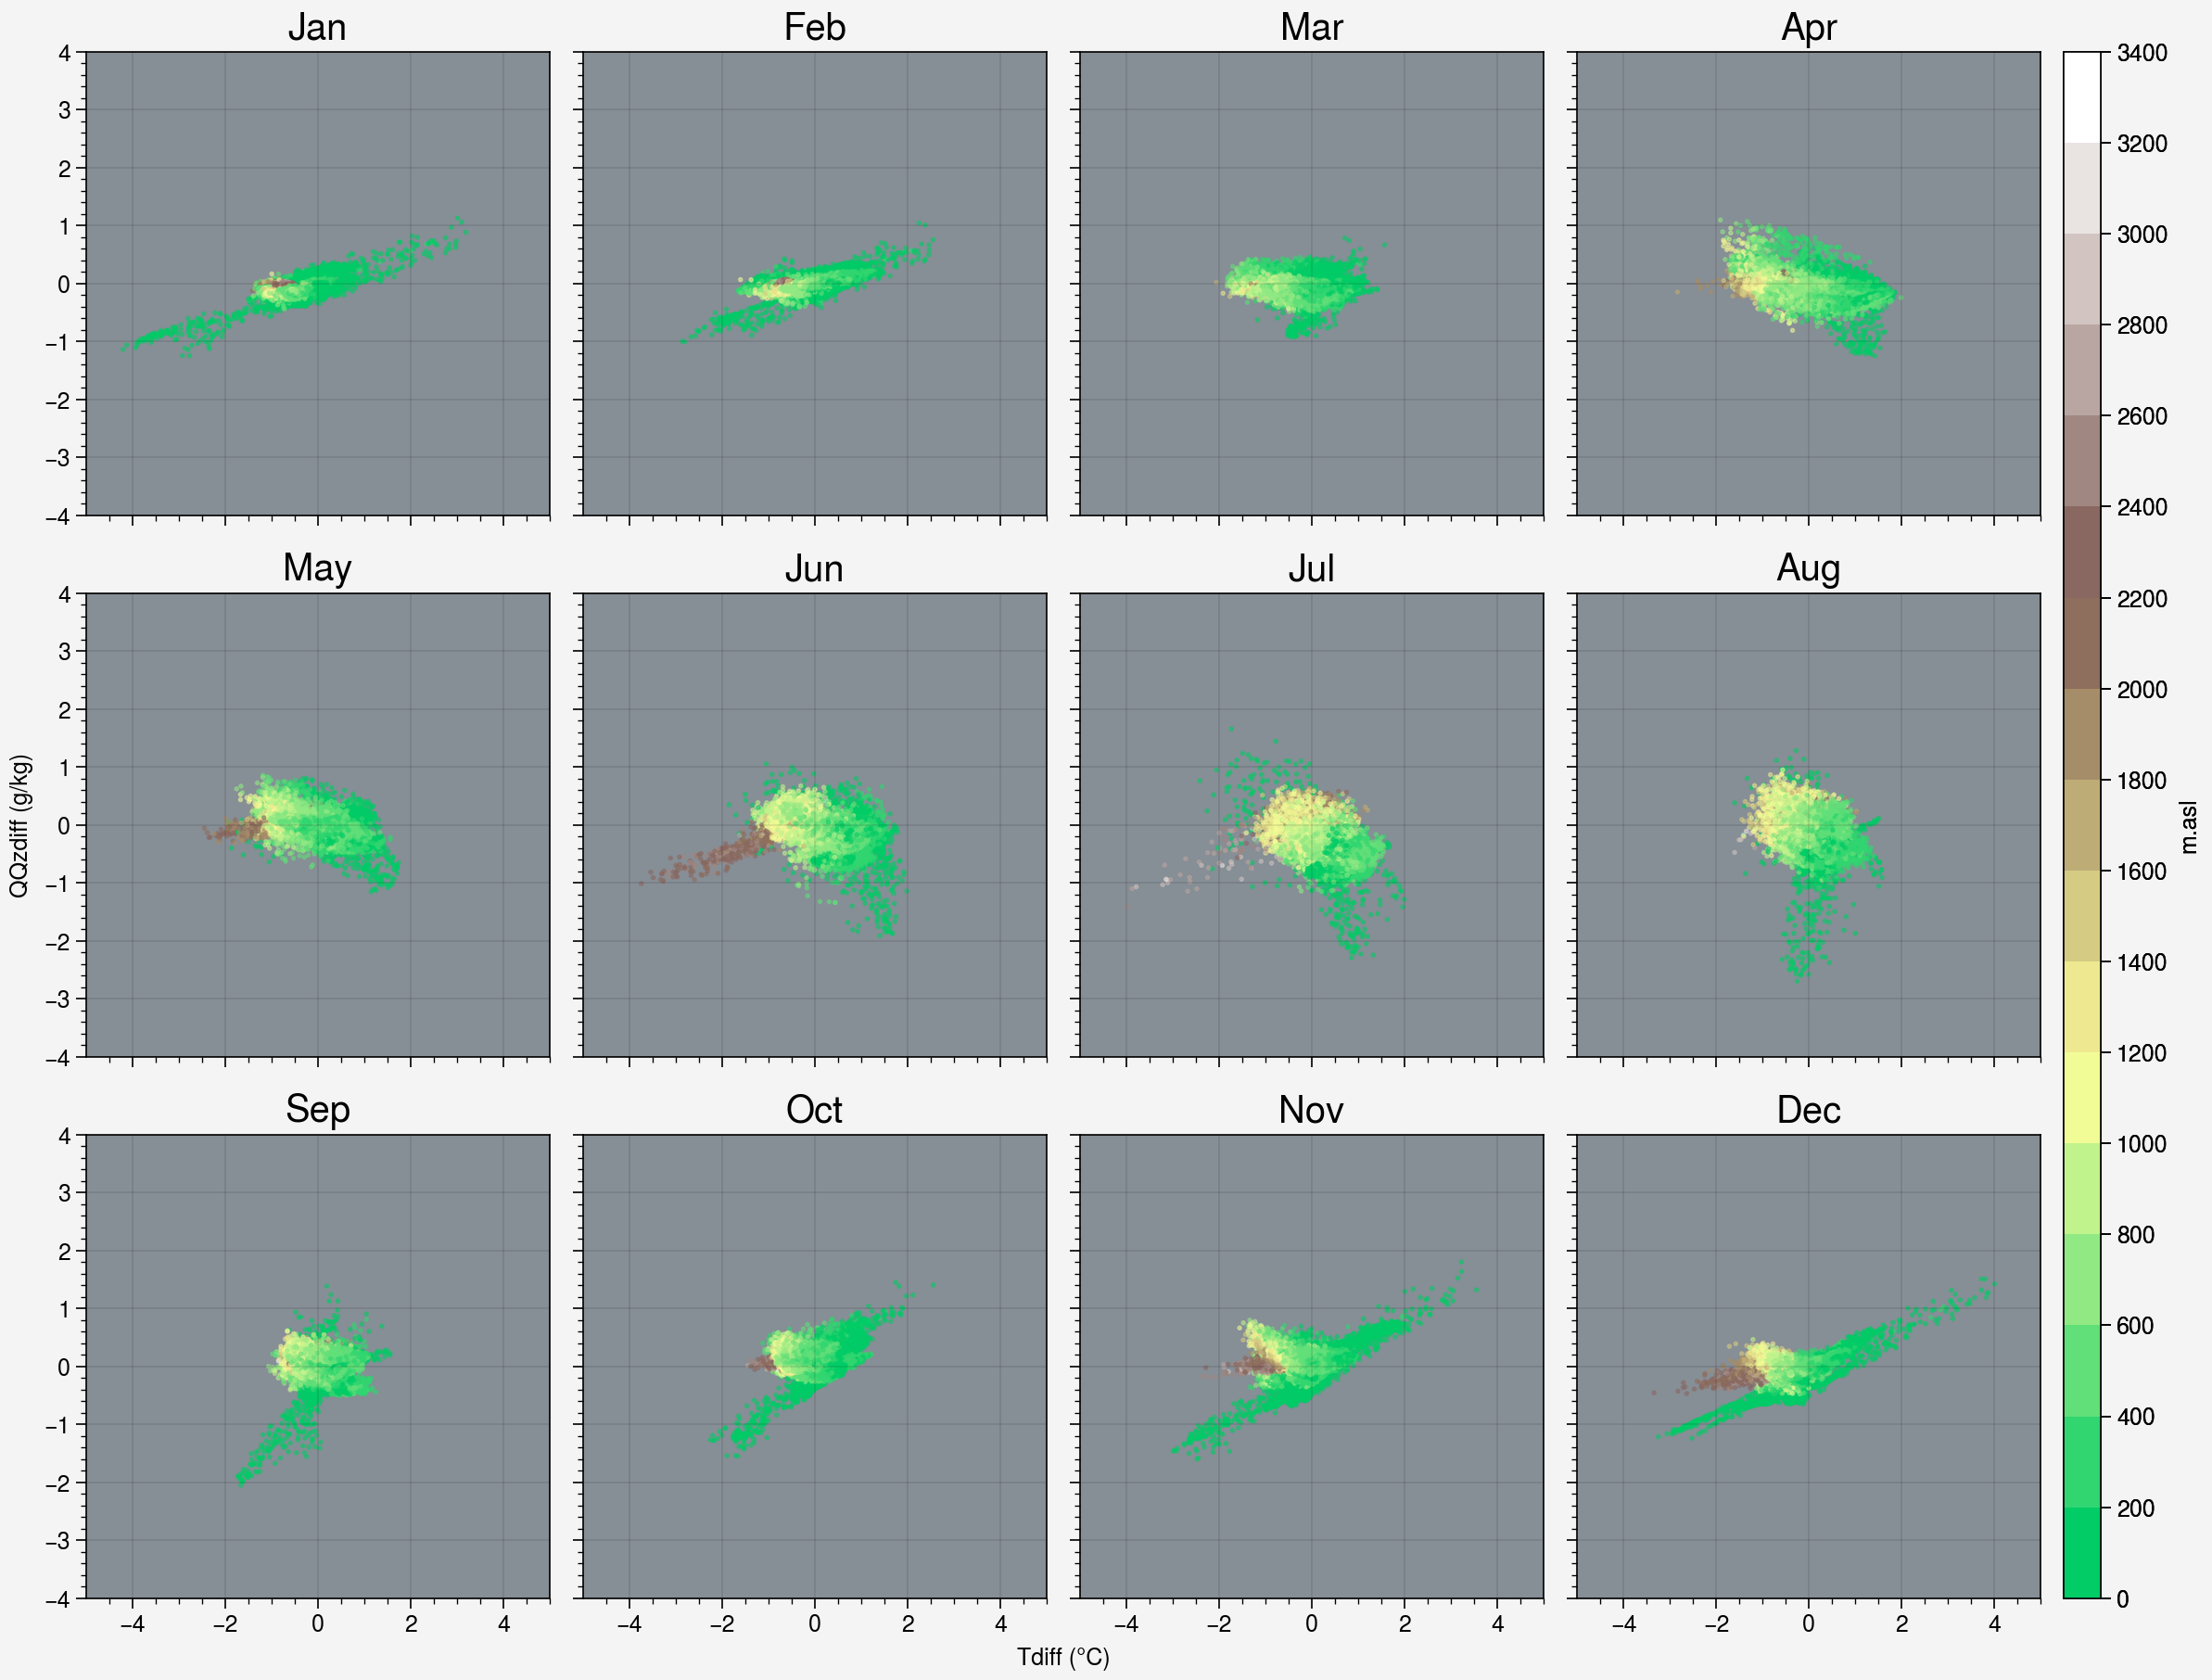

In [56]:
with pplt.rc.context({'axesfacecolor': 'gray6'}):
    f, axs = pplt.subplots(ncols=4,nrows=3)



for mon in range(12):
    ax = axs[mon]
    m = ax.scatter(monthlyT_diff_2015[mon].flatten(),monthlyQQz_diff_2015[mon].flatten(),s=2,alpha=0.5,c=H.flatten(),cmap=colors_land,levels=17) # *100 to put in percent
    ax.set_xlim((-5.,5))
    ax.set_ylim((-4.,4))
    ax.format(title=months[mon],titlesize='20px')

cbar = f.colorbar(m,label= 'm.asl')
cbar.solids.set(alpha=1)

axs.format(xlabel='Tdiff (°C)',ylabel='QQzdiff (g/kg)')